<a href="https://colab.research.google.com/github/seohyun126/ASCEND/blob/main/2_EDA_%26_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 데이터 불러오기**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os
import gc
import pyarrow.parquet as pq
import time

In [ ]:
### Google Colab 활용 시 필요

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2024 BDA 연합공모전_코인채굴꾼/OHLCV.csv')
df

Time     Open     High      Low    Close    Volume
0     2023-01-01 00:00:00  16537.5  16540.9  16504.0  16527.0  5381.399
1     2023-01-01 01:00:00  16527.1  16554.3  16524.1  16550.4  3210.826
2     2023-01-01 02:00:00  16550.5  16557.1  16534.8  16542.4  2399.668
3     2023-01-01 03:00:00  16542.5  16542.5  16515.0  16529.3  3214.480
4     2023-01-01 04:00:00  16529.2  16530.4  16508.8  16517.8  3150.954
...                   ...      ...      ...      ...      ...       ...
9403  2024-01-27 19:00:00  41785.0  41977.0  41775.1  41896.4  7765.565
9404  2024-01-27 20:00:00  41896.5  42070.0  41896.4  42049.6  5408.243
9405  2024-01-27 21:00:00  42049.6  42165.6  42001.8  42137.8  5859.277
9406  2024-01-27 22:00:00  42137.8  42187.1  42057.6  42135.3  5271.863
9407  2024-01-27 23:00:00  42135.4  42156.7  42055.4  42102.2  4399.800

[9408 rows x 6 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    9408 non-null   object 
 1   Open    9408 non-null   float64
 2   High    9408 non-null   float64
 3   Low     9408 non-null   float64
 4   Close   9408 non-null   float64
 5   Volume  9408 non-null   float64
dtypes: float64(5), object(1)
memory usage: 441.1+ KB


In [ ]:
### Time 처리

df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9408 entries, 2023-01-01 00:00:00 to 2024-01-27 23:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    9408 non-null   float64
 1   High    9408 non-null   float64
 2   Low     9408 non-null   float64
 3   Close   9408 non-null   float64
 4   Volume  9408 non-null   float64
dtypes: float64(5)
memory usage: 441.0 KB


In [ ]:
df.describe()

Open          High           Low         Close         Volume
count   9408.000000   9408.000000   9408.000000   9408.000000    9408.000000
mean   29771.803178  29865.354645  29676.537495  29774.602227   16876.182314
std     6740.667365   6768.684152   6708.999383   6740.419939   20454.652408
min    16504.300000  16524.900000  16488.000000  16504.200000     233.360000
25%    26033.350000  26079.650000  25981.575000  26033.925000    6014.381500
50%    28007.350000  28110.500000  27909.650000  28009.250000   10402.521000
75%    31043.700000  31199.100000  30892.775000  31047.200000   19316.104250
max    48577.100000  49027.500000  47209.800000  48577.900000  355275.447000

# **2. EDA & Feature 예측**

In [ ]:
### 시계열 분석 패키지(ACF, PACF)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## **2-1. 캔들(Candle) 차트**
- 캔들 차트를 통해 OHLCV 데이터를 시각화 해보자.


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.subplots as ms
import plotly.express as px

In [ ]:
# 캔들차트 생성
candle = go.Candlestick(
    x = df.index,
    open = df['Open'],
    high = df['High'],
    low = df['Low'],
    close = df['Close'],

    increasing_line_color = 'red', # 상승봉 스타일링
    decreasing_line_color = 'blue', # 하락봉 스타일링
    line = dict(width = 5)
)

fig = go.Figure(data = candle)
fig.update_layout(title_text="OHLCV", title_x=0.5)
fig.show()

## **2-2. 시가(Open)**

### **a) 시계열 분석**

#### **시도표**

In [ ]:
fig = go.Figure()

# 시가 라인 플롯 추가
fig.add_trace(go.Scatter(x=df.index, y=df['Open'], mode='lines', name='Open', line=dict(color='red')))

# 레이아웃 설정
fig.update_layout(title_text="Open", title_x=0.5)

# 차트 출력
fig.show()

#### **시계열 분해**

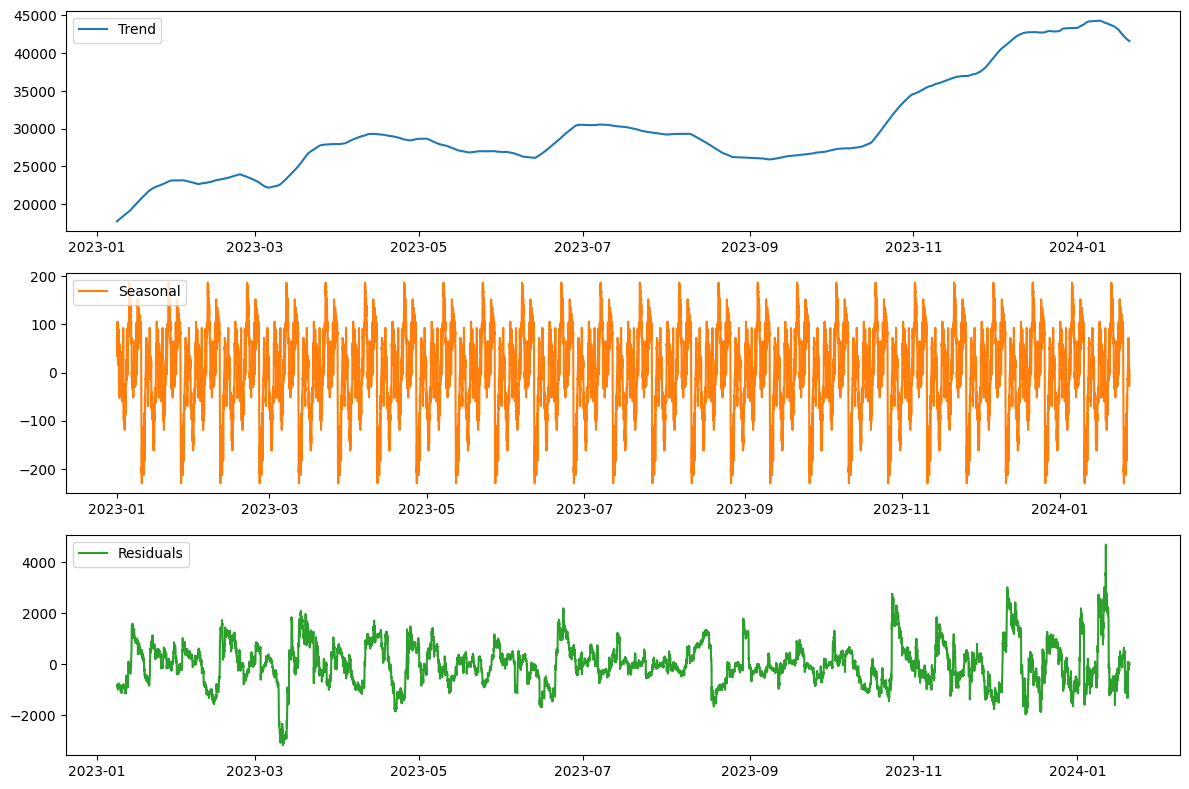

In [ ]:
# 시계열 분해
result = sm.tsa.seasonal_decompose(df['Open'], model='additive', period=365)

# 색상 설정
colors = plt.cm.tab10.colors

# 시각화
plt.figure(figsize=(12, 8))

# 추세(Trend)
plt.subplot(3, 1, 1)
plt.plot(df.index, result.trend, label='Trend', color=colors[0])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 계절성(Seasonality)
plt.subplot(3, 1, 2)
plt.plot(df.index, result.seasonal, label='Seasonal', color=colors[1])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 잔차(Residuals) 분석
plt.subplot(3, 1, 3)
plt.plot(df.index, result.resid, label='Residuals', color=colors[2])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 레이아웃 조정
plt.tight_layout()

# 시각화 표시
plt.show()

- 추세(Trend)
  - 우상향 추세를 보인다.

- 계절성(Seasonality)
  - 월 단위로 계절적 주기성을 보인다.
- 잔차 분석
  - 잔차에 어떠한 패턴을 보이고 있지는 않다.

#### **정상성**

**ACF/PACF**

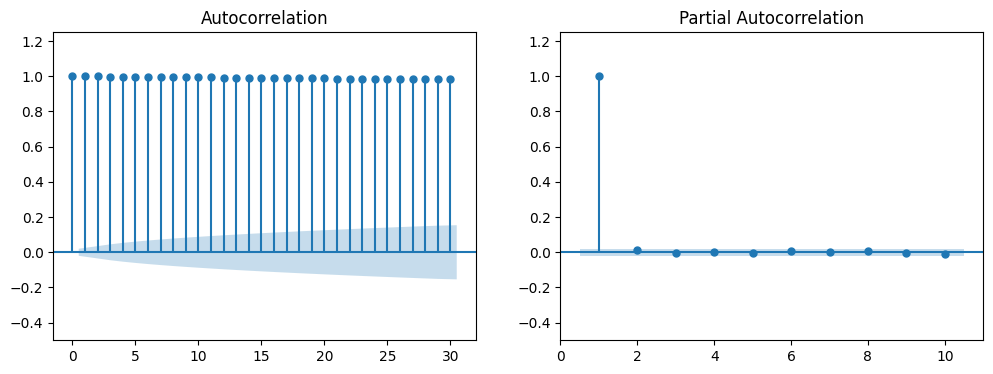

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

# ACF Plot
plot_acf(df['Open'], lags=30, ax=axes[0])
# PACF Plot
plot_pacf(df['Open'], lags=10, zero=False, ax=axes[1])

for ax in axes:
    ax.set_ylim(-0.5, 1.25)
plt.show()

- ACF의 경우 점차 감소하며 0에 수렴하는 형태를 보인다.
- PACF의 경우 시차 1 이후에 0이다.

> AR(1) 모형을 적용할 수 있다.

**ADF 검정**
- H0: 해당 시계열은 비정상(non-stationary) 시계열이다. <-> H1: 해당 시계열은 정상(stationary) 시계열이다.
  - p-value <= 0.05 : 귀무가설 기각/ 대립가설 채택 -> 정상(stationary) 시계열
  - p-value > 0.05 : 귀무가설 채택/ 대립가설 기각 -> 비정상(non-stationary) 시계열

In [ ]:
from statsmodels.tsa.stattools import adfuller #ADF Test를 위한 함수 호출

In [ ]:
def adfuller_test(series, **kw):
    adf, p_value, nlags, number_of_observations, critical_values, _ = adfuller(series, **kw)

    print(f'ADF: {adf:.5f}')
    print(f'p-value: {p_value:.2f}')
    print(f'Lags: {nlags}')
    print(f'Number of Observations: {number_of_observations}')

    print(f'검증결과: {"비정상(non-stationary)" if p_value > 0.05 else "정상(stationary)"} 시계열 데이터입니다.')

In [ ]:
# Adfuller 테스트

adfuller_test(df['Open'], maxlag=30)

ADF: -1.17356
p-value: 0.68
Lags: 23
Number of Observations: 9384
검증결과: 비정상(non-stationary) 시계열 데이터입니다.


In [ ]:
# 1차 차분 후 검정

adfuller_test(df['Open'].diff(periods=1).iloc[1:], maxlag=30)

ADF: -17.96194
p-value: 0.00
Lags: 30
Number of Observations: 9376
검증결과: 정상(stationary) 시계열 데이터입니다.


### **b) 예측**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#### **ARIMA**

In [ ]:
# !pip install pmdarima

In [ ]:
import pandas as pd
from pmdarima import auto_arima
from datetime import timedelta
from tqdm import tqdm

In [ ]:
# auto_arima를 사용하여 최적 모델 찾기

from pmdarima.arima import auto_arima

# m=0 : non-seasonal
open_arima = auto_arima(df['Open'],
                        test='adf', # 정상성 검정
                        trace=True,
                        error_action='ignore',
                        max_p = 5, max_q = 4,max_d = 3,
                        suppress_warnings=True,
                        stepwise=True,
                        seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=120204.951, Time=20.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=120218.254, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=120203.503, Time=1.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120204.224, Time=2.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=120219.607, Time=0.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=120201.275, Time=1.60 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=120203.027, Time=2.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=120203.060, Time=7.91 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=120201.909, Time=3.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=120205.007, Time=1.67 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=120202.771, Time=0.49 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 42.855 seconds


In [ ]:
open_arima.summary() # 좋은 결과라고 보긴 어렵다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9408
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -60096.637
Date:                Sat, 03 Feb 2024   AIC                         120201.275
Time:                        12:38:41   BIC                         120229.872
Sample:                    01-01-2023   HQIC                        120210.984
                         - 01-27-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.7753      1.491      1.861      0.063      -0.148       5.698
ar.L1         -0.0413      0.004     -9.495      0.000      -0.050      -0.033
ar.L2          0.0212      0.006      3.381      0.001       0.009       0.033
sigma2      2.073e+04     87.850    235.969      0.000    2.06e+04    2.09e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            195858.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
### 예측
# 미래에 대한 예측을 위한 기간 설정
future_periods = 73
future_dates = [df.index.max() + timedelta(hours=i) for i in range(1, future_periods + 1)]

# 최적 모델을 사용하여 예측 수행
pred_open = open_arima.predict(n_periods=future_periods)

# 예측 결과를 DataFrame으로 저장
pred_open_arima = pd.DataFrame({'Open': pred_open}, index=future_dates)
pred_open_arima

Open
2024-01-28 00:00:00  42140.144144
2024-01-28 01:00:00  42142.672817
2024-01-28 02:00:00  42145.444362
2024-01-28 03:00:00  42148.158919
2024-01-28 04:00:00  42150.880975
...                           ...
2024-01-30 20:00:00  42325.007208
2024-01-30 21:00:00  42327.727933
2024-01-30 22:00:00  42330.448658
2024-01-30 23:00:00  42333.169382
2024-01-31 00:00:00  42335.890107

[73 rows x 1 columns]

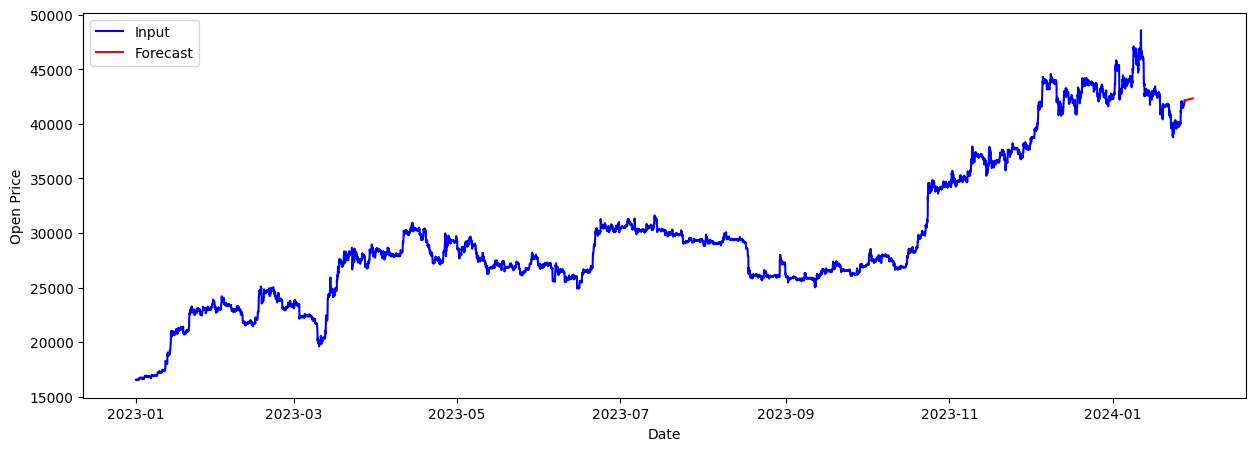

In [ ]:
### 시각화
plt.figure(figsize = (15, 5))

plt.plot(df['Open'], label='Input', color='blue')
plt.plot(pred_open_arima, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()

#### **Prophet**

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.model_selection import ParameterGrid

In [ ]:
# Prophet에 사용할 열만 선택 (ds: 시간, y: 예측 변수)

prophet_open = df[['Open']]
prophet_open['ds'] = df.index
prophet_open.columns = ['y', 'ds']
prophet_open

y                  ds
Time                                            
2023-01-01 00:00:00  16537.5 2023-01-01 00:00:00
2023-01-01 01:00:00  16527.1 2023-01-01 01:00:00
2023-01-01 02:00:00  16550.5 2023-01-01 02:00:00
2023-01-01 03:00:00  16542.5 2023-01-01 03:00:00
2023-01-01 04:00:00  16529.2 2023-01-01 04:00:00
...                      ...                 ...
2024-01-27 19:00:00  41785.0 2024-01-27 19:00:00
2024-01-27 20:00:00  41896.5 2024-01-27 20:00:00
2024-01-27 21:00:00  42049.6 2024-01-27 21:00:00
2024-01-27 22:00:00  42137.8 2024-01-27 22:00:00
2024-01-27 23:00:00  42135.4 2024-01-27 23:00:00

[9408 rows x 2 columns]

**기본 모델**

In [ ]:
# 로그 끄기

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [ ]:
# 모델 객체 생성
m_open = Prophet()
# 학습
m_open.fit(prophet_open)
# 예측
future = m_open.make_future_dataframe(periods = 73, freq='H')
forecast = m_open.predict(future)

In [ ]:
forecast.tail(73)[['ds', 'yhat']]

ds          yhat
9408 2024-01-28 00:00:00  44720.995850
9409 2024-01-28 01:00:00  44732.020623
9410 2024-01-28 02:00:00  44736.024551
9411 2024-01-28 03:00:00  44735.171121
9412 2024-01-28 04:00:00  44734.377611
...                  ...           ...
9476 2024-01-30 20:00:00  45076.942069
9477 2024-01-30 21:00:00  45083.986742
9478 2024-01-30 22:00:00  45093.362116
9479 2024-01-30 23:00:00  45107.299537
9480 2024-01-31 00:00:00  45122.907356

[73 rows x 2 columns]

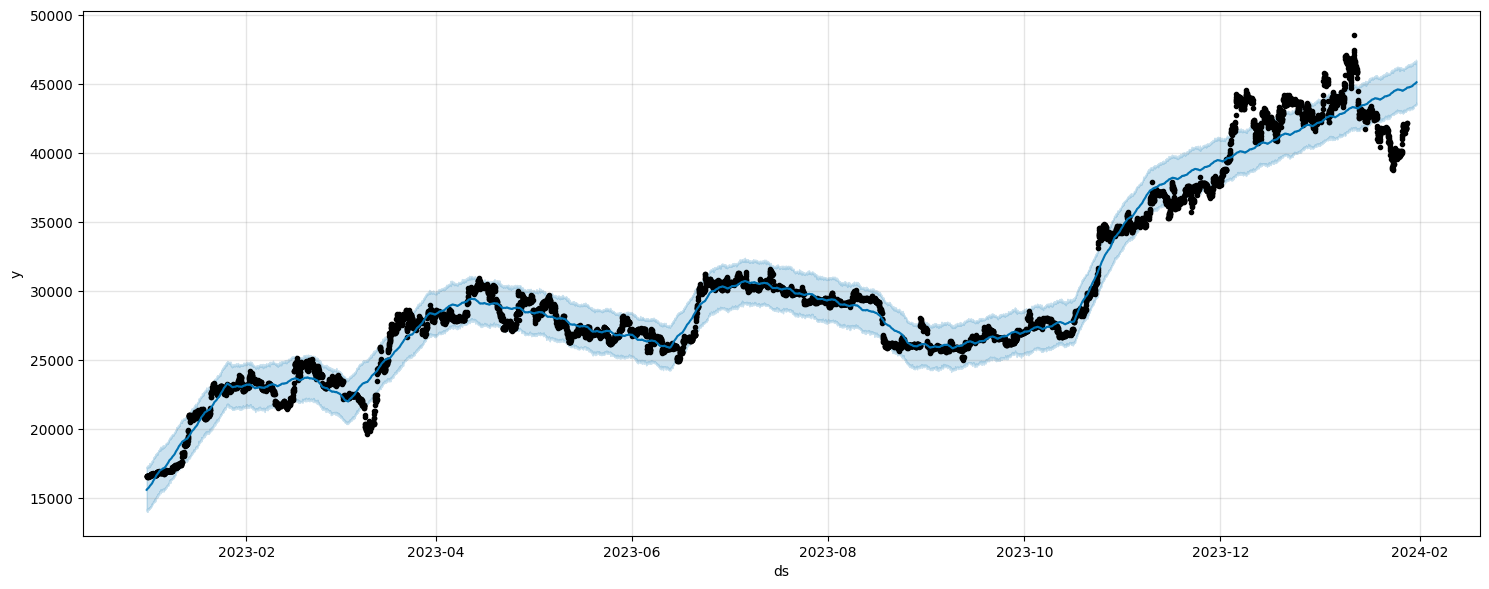

In [ ]:
### 시각화
fig = m_open.plot(forecast, figsize=(15, 6))

- 우상향 할 것이라고 예측하고 있다.

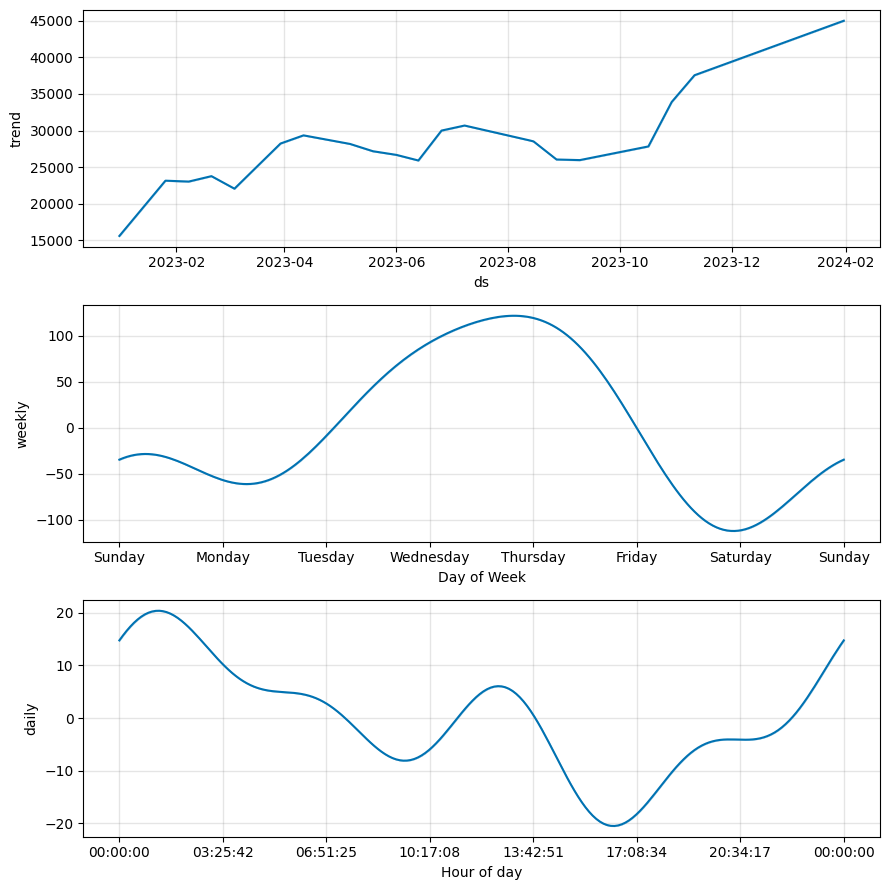

In [ ]:
### 컴포넌트 별 시각화

fig2 = m_open.plot_components(forecast)

- 우상향 추세를 보인다.
- 주간, 일간 계절성이 보인다.

**파라미터 튜닝**

In [ ]:
# 파라미터 그리드 정의
param_grid = {
    ## 추세
    'changepoint_prior_scale': [0.01, 0.05],  # 변곡점의 유연성
    ## 계절성
    'seasonality_mode': ['additive'],
    'yearly_seasonality': [False],  # 연간 계절성
    'weekly_seasonality': [True],  # 주간 계절성
    'daily_seasonality': [True],  # 일간 계절성
    'seasonality_prior_scale': [0.1, 1.0],  # 계절성의 유연성
     ## 휴일
    'holidays_prior_scale': [0.1, 1.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
best_params = None
best_rmse = float('inf')

# 파리미터 평가를 위해 cv 진행
for i, params in enumerate(all_params, 1):
  print(f"Parameter tuning iteration {i}/{len(all_params)}")

  m = Prophet(**params).fit(prophet_open)
  df_cv = cross_validation(m, initial='1000 hours', period='360 hours', horizon='73 hours', parallel="processes")
  df_p = performance_metrics(df_cv, rolling_window=1)
  rmse = df_p['rmse'].values[0]

  print(f"RMSE: {rmse}")
  print()

  if rmse < best_rmse:
    best_rmse = rmse
    best_params = params

print("\nBest parameters:")
print(best_params)

Parameter tuning iteration 1/8
RMSE: 2096.059346778898

Parameter tuning iteration 2/8
RMSE: 2096.059346778898

Parameter tuning iteration 3/8
RMSE: 2096.5744295919712

Parameter tuning iteration 4/8
RMSE: 2096.5744295919712

Parameter tuning iteration 5/8
RMSE: 2014.4180155573247

Parameter tuning iteration 6/8
RMSE: 2014.4180155573247

Parameter tuning iteration 7/8
RMSE: 2014.8977642210432

Parameter tuning iteration 8/8
RMSE: 2014.8977642210432


Best parameters:
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1}


In [ ]:
# 최적 모델로 fitting
open_prophet = Prophet(**best_params).fit(prophet_open)

# Make predictions
future = open_prophet.make_future_dataframe(periods=73, freq='H')
pred_open_prophet = open_prophet.predict(future)

In [ ]:
pred_open_prophet.tail(73)[['ds', 'yhat']]

ds          yhat
9408 2024-01-28 00:00:00  44719.719547
9409 2024-01-28 01:00:00  44730.709378
9410 2024-01-28 02:00:00  44734.687214
9411 2024-01-28 03:00:00  44733.816410
9412 2024-01-28 04:00:00  44733.009413
...                  ...           ...
9476 2024-01-30 20:00:00  45075.650158
9477 2024-01-30 21:00:00  45082.708276
9478 2024-01-30 22:00:00  45092.086921
9479 2024-01-30 23:00:00  45106.017527
9480 2024-01-31 00:00:00  45121.614180

[73 rows x 2 columns]

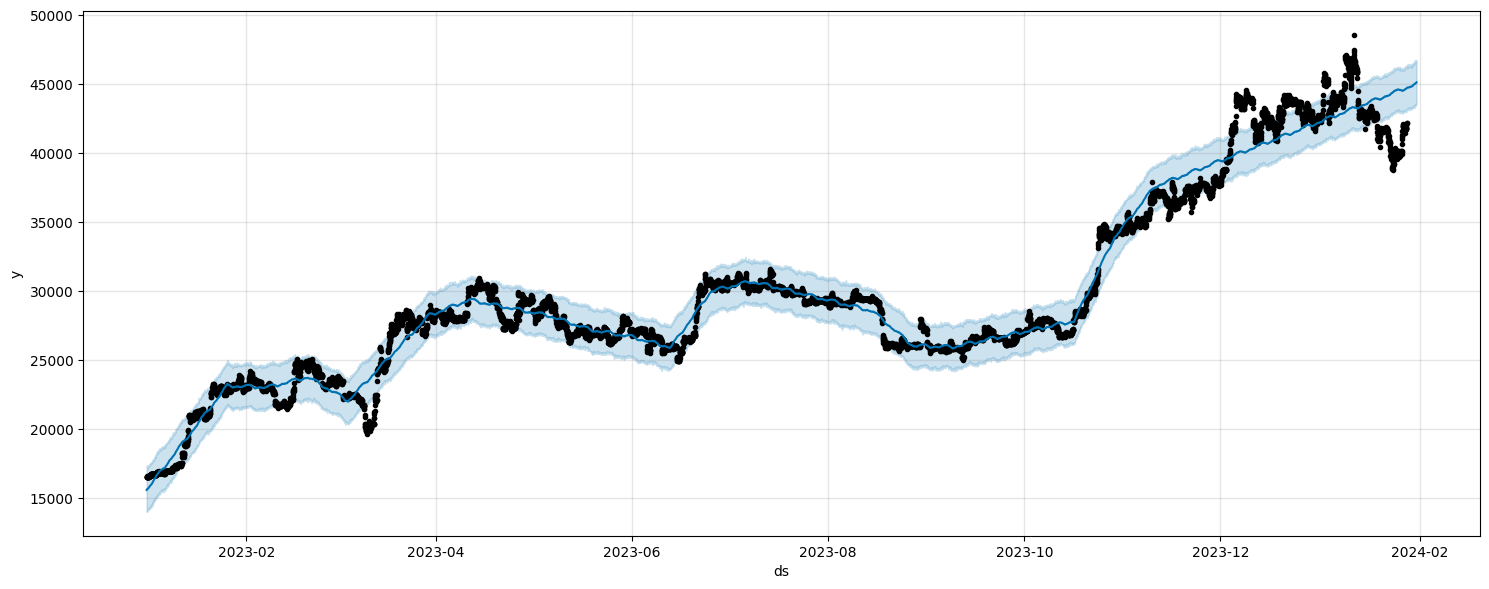

In [ ]:
### 시각화
fig3 = open_prophet.plot(pred_open_prophet, figsize=(15, 6))

#### **최종**
- 일정한 비율로 혼합하여 최종 예측값으로 채택

In [ ]:
pred_open_final = pred_open_arima['Open'].values * 0.4 + pred_open_prophet.tail(73)['yhat'] * 0.6
pred_open_final

9408    43687.889385
9409    43695.494754
9410    43698.990073
9411    43699.553413
9412    43700.158038
            ...     
9476    43975.392978
9477    43980.716139
9478    43987.431616
9479    43996.878269
9480    44007.324551
Name: yhat, Length: 73, dtype: float64

## **2-3. 고가(High)**

### **a) 시계열 분석**

#### **시도표**

In [ ]:
fig = go.Figure()

# 시가 라인 플롯 추가
fig.add_trace(go.Scatter(x=df.index, y=df['High'], mode='lines', name='High', line=dict(color='orange')))

# 레이아웃 설정
fig.update_layout(title_text="High", title_x=0.5)

# 차트 출력
fig.show()

#### **시계열 분해**

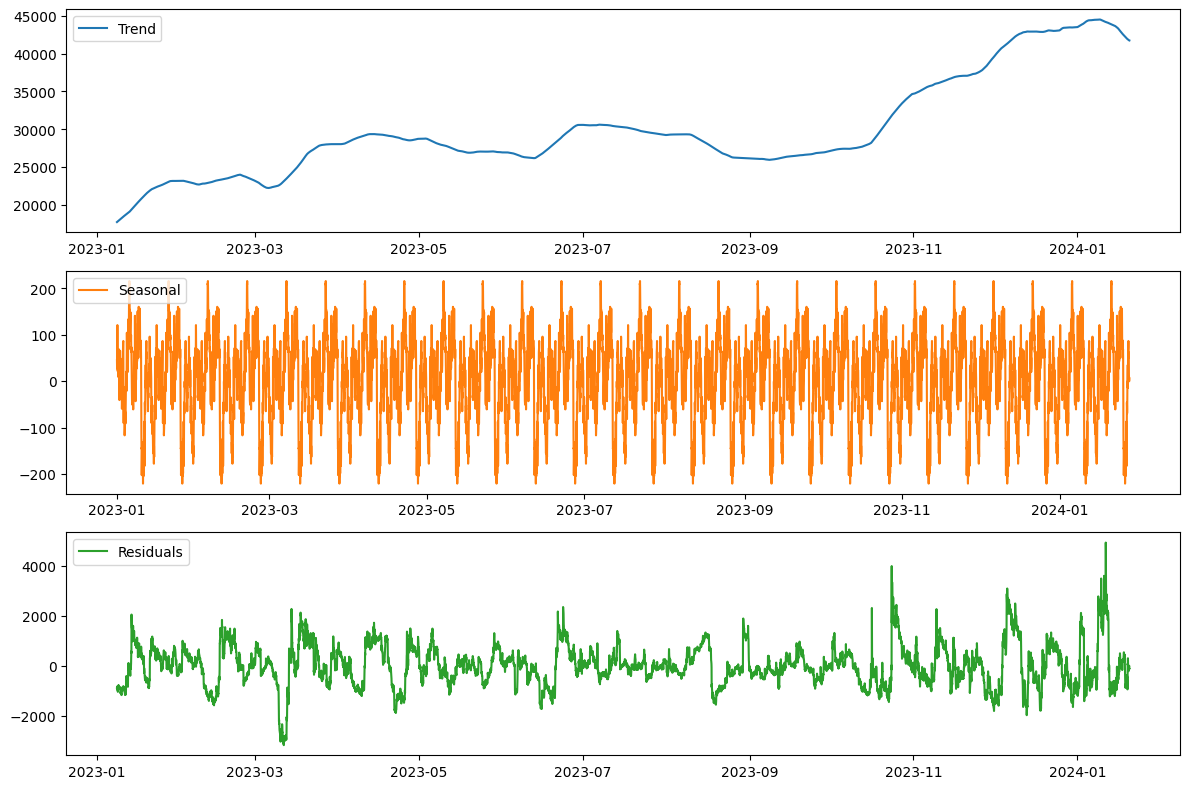

In [ ]:
## 시계열 분해
result = sm.tsa.seasonal_decompose(df['High'], model='additive', period=365)

# 색상 설정
colors = plt.cm.tab10.colors

## 시각화
plt.figure(figsize=(12, 8))

# 추세(Trend)
plt.subplot(3, 1, 1)
plt.plot(df.index, result.trend, label='Trend', color=colors[0])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 계절성(Seasonality)
plt.subplot(3, 1, 2)
plt.plot(df.index, result.seasonal, label='Seasonal', color=colors[1])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 잔차(Residuals) 분석
plt.subplot(3, 1, 3)
plt.plot(df.index, result.resid, label='Residuals', color=colors[2])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 레이아웃 조정
plt.tight_layout()

# 시각화 표시
plt.show()

- 추세(Trend)
  - 우상향 추세를 보인다.

- 계절성(Seasonality)
  - 월 단위로 계절적 주기성을 보인다.
- 잔차 분석
  - 잔차에 어떠한 패턴을 보이고 있지는 않다.

#### **정상성**

**ACF/PACF**

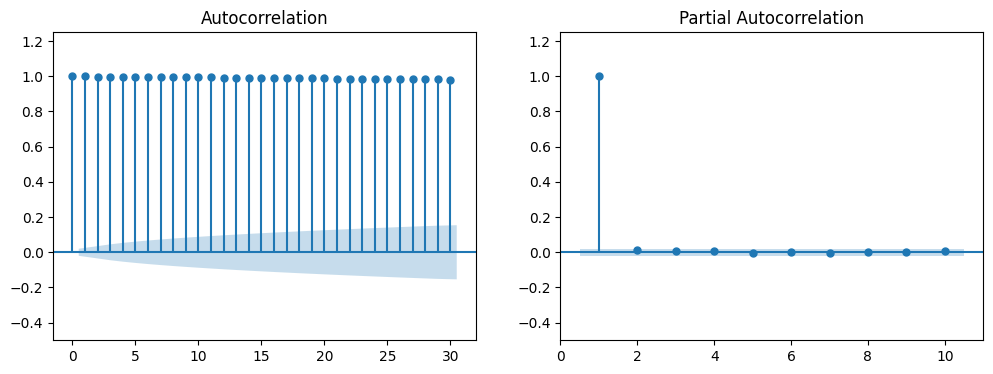

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

# ACF Plot
plot_acf(df['High'], lags=30, ax=axes[0])
# PACF Plot
plot_pacf(df['High'], lags=10, zero=False, ax=axes[1])

for ax in axes:
    ax.set_ylim(-0.5, 1.25)
plt.show()

- ACF의 경우 점차 감소하며 0에 수렴하는 형태를 보인다.
- PACF의 경우 시차 1 이후에 0이다.

> AR(1) 모형을 적용할 수 있다.

**ADF 검정**
- H0: 해당 시계열은 비정상(non-stationary) 시계열이다. <-> H1: 해당 시계열은 정상(stationary) 시계열이다.
  - p-value <= 0.05 : 귀무가설 기각/ 대립가설 채택 -> 정상(stationary) 시계열
  - p-value > 0.05 : 귀무가설 채택/ 대립가설 기각 -> 비정상(non-stationary) 시계열

In [ ]:
# Adfuller 테스트

adfuller_test(df['High'], maxlag=30)

ADF: -1.17586
p-value: 0.68
Lags: 3
Number of Observations: 9404
검증결과: 비정상(non-stationary) 시계열 데이터입니다.


In [ ]:
# 1차 차분 후 검정

adfuller_test(df['High'].diff(periods=1).iloc[1:], maxlag=30)

ADF: -58.50866
p-value: 0.00
Lags: 2
Number of Observations: 9404
검증결과: 정상(stationary) 시계열 데이터입니다.


### **b) 예측**

#### **ARIMA**

In [ ]:
# auto_arima를 사용하여 최적 모델 찾기

from pmdarima.arima import auto_arima

# m=0 : non-seasonal
high_arima = auto_arima(df['High'],
                        test='adf', # 정상성 검정
                        trace=True,
                        error_action='ignore',
                        max_p = 5, max_q = 4,max_d = 3,
                        suppress_warnings=True,
                        stepwise=True,
                        seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=121612.368, Time=4.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=121619.113, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=121611.783, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=121611.399, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=121620.006, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=121608.508, Time=6.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=121610.841, Time=4.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=121610.146, Time=13.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=121609.676, Time=1.92 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=121610.078, Time=1.81 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=121609.838, Time=2.63 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 36.219 seconds


In [ ]:
high_arima.summary() # 좋은 결과라고 보긴 어렵다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9408
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -60800.254
Date:                Sat, 03 Feb 2024   AIC                         121608.508
Time:                        12:53:58   BIC                         121637.105
Sample:                    01-01-2023   HQIC                        121618.218
                         - 01-27-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4041      0.885      1.587      0.113      -0.330       3.138
ar.L1          0.4896      0.104      4.687      0.000       0.285       0.694
ma.L1         -0.5239      0.104     -5.050      0.000      -0.727      -0.321
sigma2      2.407e+04     57.483    418.777      0.000     2.4e+04    2.42e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):           4082947.21
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                             3.20
Prob(H) (two-sided):                  0.00   Kurtosis:                       104.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
### 예측
# 미래에 대한 예측을 위한 기간 설정
future_periods = 73
future_dates = [df.index.max() + timedelta(hours=i) for i in range(1, future_periods + 1)]

# 최적 모델을 사용하여 예측 수행
pred_high = high_arima.predict(n_periods=future_periods)

# 예측 결과를 DataFrame으로 저장
pred_high_arima = pd.DataFrame({'High': pred_high}, index=future_dates)
pred_high_arima

High
2024-01-28 00:00:00  42158.559326
2024-01-28 01:00:00  42160.873726
2024-01-28 02:00:00  42163.410919
2024-01-28 03:00:00  42166.057188
2024-01-28 04:00:00  42168.756857
...                           ...
2024-01-30 20:00:00  42344.764676
2024-01-30 21:00:00  42347.515566
2024-01-30 22:00:00  42350.266456
2024-01-30 23:00:00  42353.017345
2024-01-31 00:00:00  42355.768235

[73 rows x 1 columns]

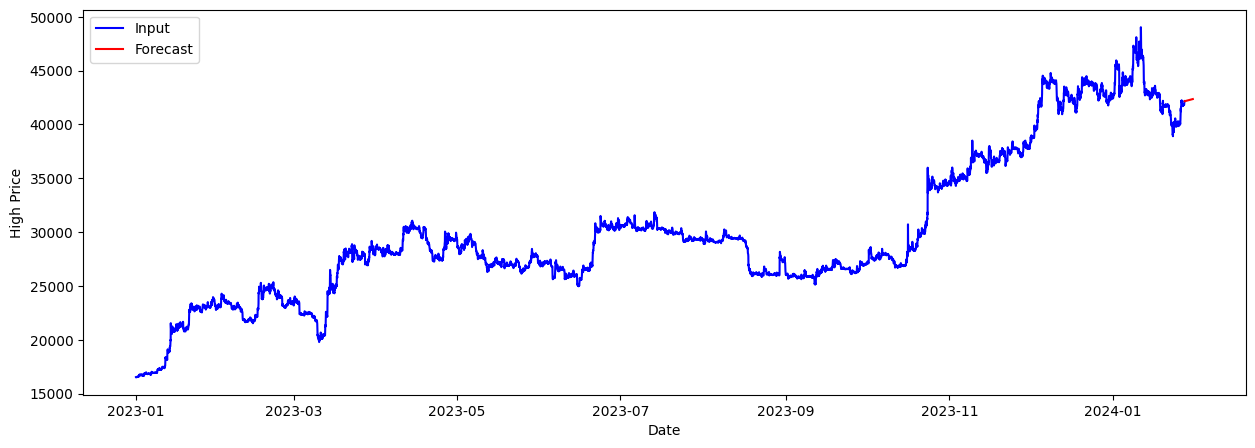

In [ ]:
### 시각화
plt.figure(figsize = (15, 5))

plt.plot(df['High'], label='Input', color='blue')
plt.plot(pred_high_arima, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.show()

#### **Prophet**

In [ ]:
# Prophet에 사용할 열만 선택 (ds: 시간, y: 예측 변수)

prophet_high = df[['High']]
prophet_high['ds'] = df.index
prophet_high.columns = ['y', 'ds']
prophet_high

y                  ds
Time                                            
2023-01-01 00:00:00  16540.9 2023-01-01 00:00:00
2023-01-01 01:00:00  16554.3 2023-01-01 01:00:00
2023-01-01 02:00:00  16557.1 2023-01-01 02:00:00
2023-01-01 03:00:00  16542.5 2023-01-01 03:00:00
2023-01-01 04:00:00  16530.4 2023-01-01 04:00:00
...                      ...                 ...
2024-01-27 19:00:00  41977.0 2024-01-27 19:00:00
2024-01-27 20:00:00  42070.0 2024-01-27 20:00:00
2024-01-27 21:00:00  42165.6 2024-01-27 21:00:00
2024-01-27 22:00:00  42187.1 2024-01-27 22:00:00
2024-01-27 23:00:00  42156.7 2024-01-27 23:00:00

[9408 rows x 2 columns]

**기본 모델**

In [ ]:
# 로그 끄기

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [ ]:
# 모델 객체 생성
m_high = Prophet()
# 학습
m_high.fit(prophet_high)
# 예측
future = m_high.make_future_dataframe(periods = 73, freq='H')
forecast = m_high.predict(future)

In [ ]:
forecast.tail(73)[['ds', 'yhat']]

ds          yhat
9408 2024-01-28 00:00:00  44848.751093
9409 2024-01-28 01:00:00  44854.506228
9410 2024-01-28 02:00:00  44848.882938
9411 2024-01-28 03:00:00  44836.579404
9412 2024-01-28 04:00:00  44828.035256
...                  ...           ...
9476 2024-01-30 20:00:00  45275.118843
9477 2024-01-30 21:00:00  45279.267475
9478 2024-01-30 22:00:00  45285.804731
9479 2024-01-30 23:00:00  45297.873891
9480 2024-01-31 00:00:00  45311.393669

[73 rows x 2 columns]

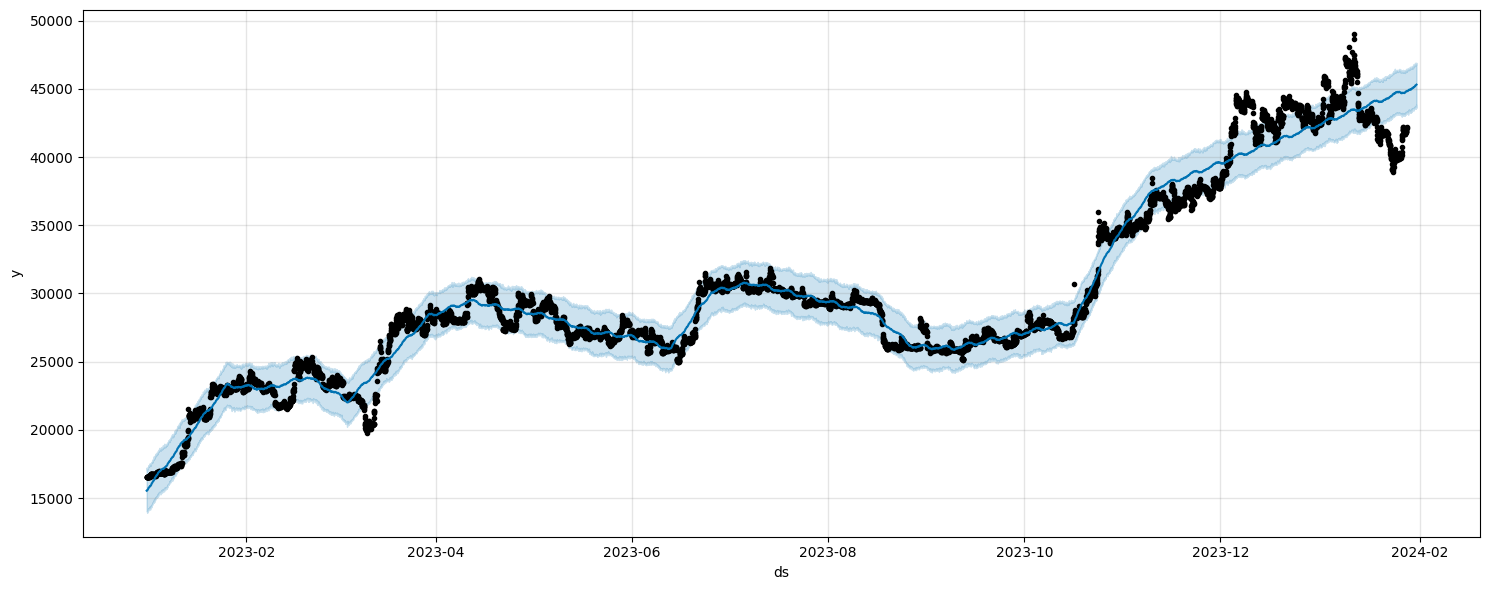

In [ ]:
### 시각화
fig = m_high.plot(forecast, figsize=(15, 6))

- 우상향 할 것이라고 예측하고 있다.

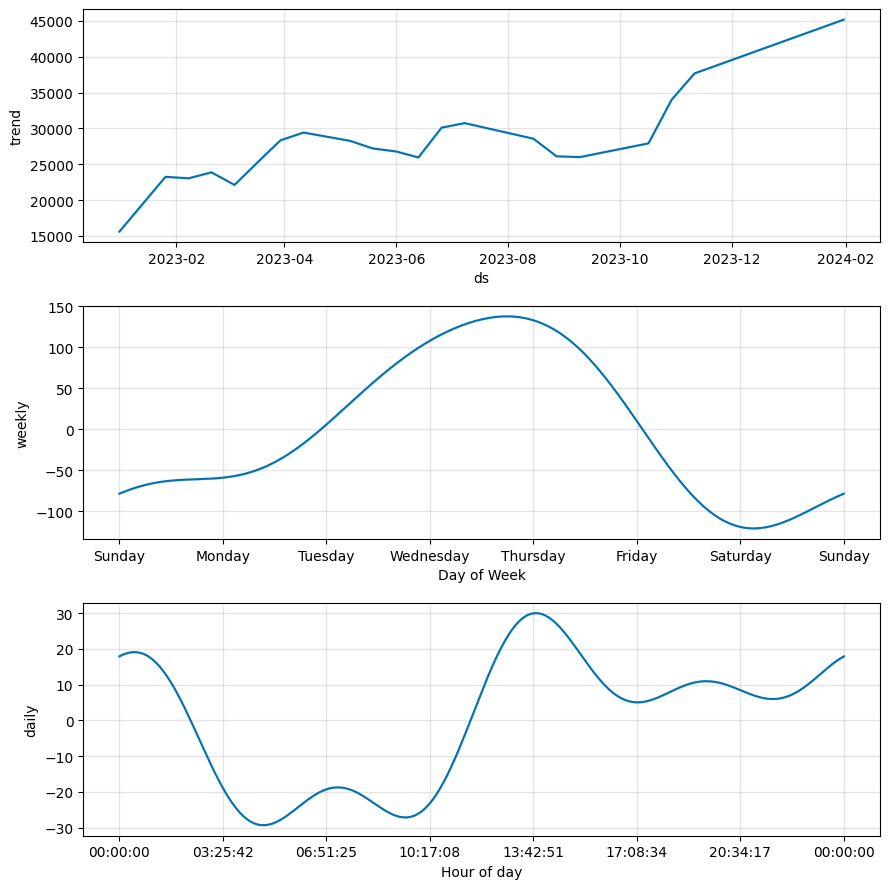

In [ ]:
### 컴포넌트 별 시각화

fig2 = m_high.plot_components(forecast)

- 우상향 추세를 보인다.
- 주간, 일간 계절성이 보인다.

**파라미터 튜닝**

In [ ]:
# 파라미터 그리드 정의
param_grid = {
    ## 추세
    'changepoint_prior_scale': [0.01, 0.05],  # 변곡점의 유연성
    ## 계절성
    'seasonality_mode': ['additive'],
    'yearly_seasonality': [False],  # 연간 계절성
    'weekly_seasonality': [True],  # 주간 계절성
    'daily_seasonality': [True],  # 일간 계절성
    'seasonality_prior_scale': [0.1, 1.0],  # 계절성의 유연성
     ## 휴일
    'holidays_prior_scale': [0.1, 1.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
best_params = None
best_rmse = float('inf')

# 파리미터 평가를 위해 cv 진행
for i, params in enumerate(all_params, 1):
  print(f"Parameter tuning iteration {i}/{len(all_params)}")

  m = Prophet(**params).fit(prophet_high)
  df_cv = cross_validation(m, initial='1000 hours', period='360 hours', horizon='73 hours', parallel="processes")
  df_p = performance_metrics(df_cv, rolling_window=1)
  rmse = df_p['rmse'].values[0]

  print(f"RMSE: {rmse}")
  print()

  if rmse < best_rmse:
    best_rmse = rmse
    best_params = params

print("\nBest parameters:")
print(best_params)

Parameter tuning iteration 1/8
RMSE: 2105.267286761048

Parameter tuning iteration 2/8
RMSE: 2105.267286761048

Parameter tuning iteration 3/8
RMSE: 2109.6106076138785

Parameter tuning iteration 4/8
RMSE: 2109.6106076138785

Parameter tuning iteration 5/8
RMSE: 2021.7916123201278

Parameter tuning iteration 6/8
RMSE: 2021.7916123201278

Parameter tuning iteration 7/8
RMSE: 2020.8450914292557

Parameter tuning iteration 8/8
RMSE: 2020.8450914292557


Best parameters:
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1}


In [ ]:
# 최적 모델로 fitting
high_prophet = Prophet(**best_params).fit(prophet_high)

# Make predictions
future = high_prophet.make_future_dataframe(periods=73, freq='H')
pred_high_prophet = high_prophet.predict(future)

In [ ]:
pred_high_prophet.tail(73)[['ds', 'yhat']]

ds          yhat
9408 2024-01-28 00:00:00  44851.699200
9409 2024-01-28 01:00:00  44857.445414
9410 2024-01-28 02:00:00  44851.811119
9411 2024-01-28 03:00:00  44839.497026
9412 2024-01-28 04:00:00  44830.946209
...                  ...           ...
9476 2024-01-30 20:00:00  45278.418362
9477 2024-01-30 21:00:00  45282.568196
9478 2024-01-30 22:00:00  45289.102998
9479 2024-01-30 23:00:00  45301.167241
9480 2024-01-31 00:00:00  45314.680261

[73 rows x 2 columns]

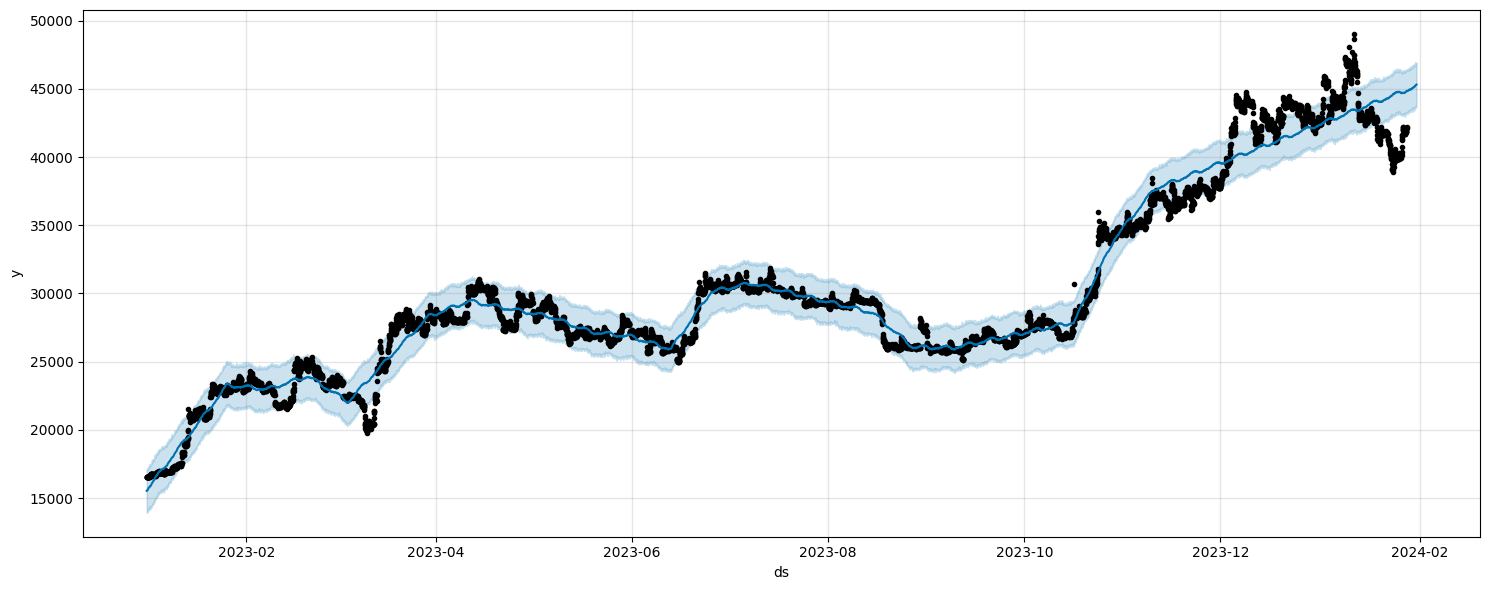

In [ ]:
### 시각화
fig3 = high_prophet.plot(pred_high_prophet, figsize=(15, 6))

#### **최종**
- 일정한 비율로 혼합하여 최종 예측값으로 채택

In [ ]:
pred_high_final = pred_high_arima['High'].values * 0.4 + pred_high_prophet.tail(73)['yhat'] * 0.6
pred_high_final

9408    43774.443251
9409    43778.816738
9410    43776.451039
9411    43770.121091
9412    43766.070468
            ...     
9476    44104.956888
9477    44108.547144
9478    44113.568381
9479    44121.907283
9480    44131.115451
Name: yhat, Length: 73, dtype: float64

## **2-4. 저가(Low)**

### **a) 시계열 분석**

#### **시도표**

In [ ]:
fig = go.Figure()

# 시가 라인 플롯 추가
fig.add_trace(go.Scatter(x=df.index, y=df['Low'], mode='lines', name='Low', line=dict(color='green')))

# 레이아웃 설정
fig.update_layout(title_text="Low", title_x=0.5)

# 차트 출력
fig.show()

#### **시계열 분해**

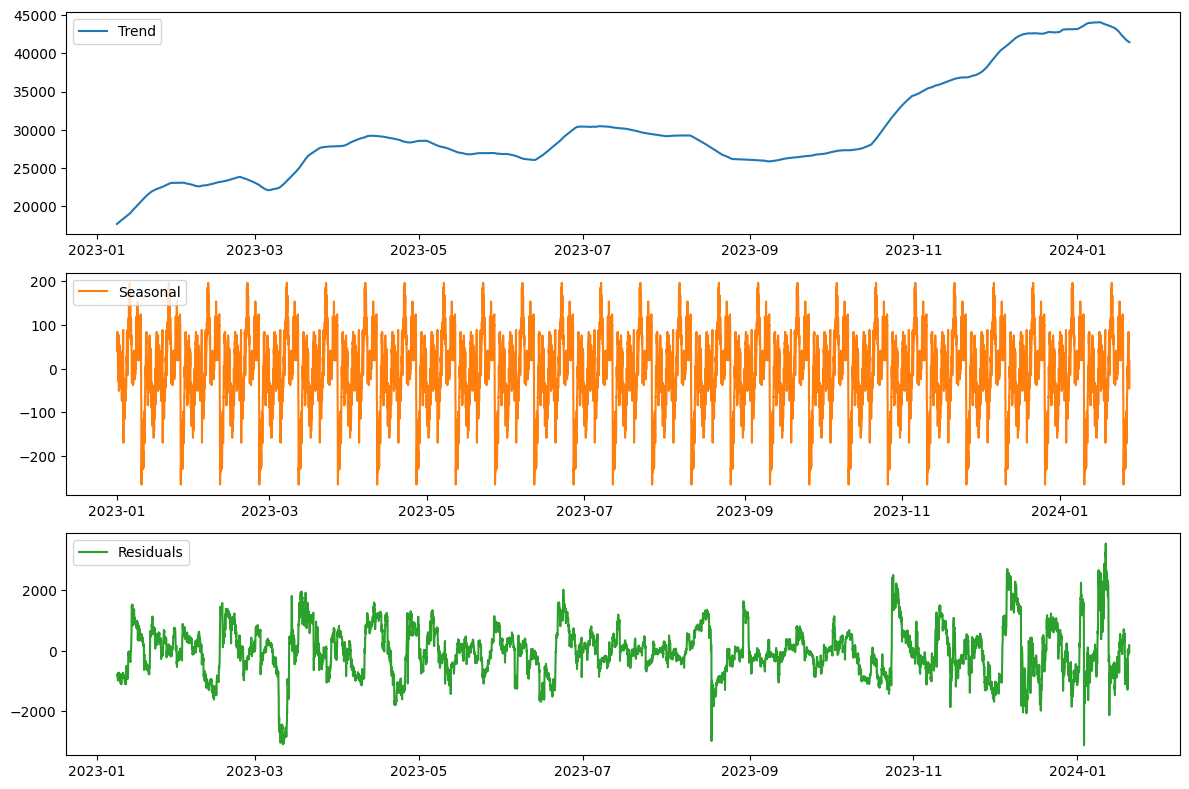

In [ ]:
## 시계열 분해
result = sm.tsa.seasonal_decompose(df['Low'], model='additive', period=365)

# 색상 설정
colors = plt.cm.tab10.colors

## 시각화
plt.figure(figsize=(12, 8))

# 추세(Trend)
plt.subplot(3, 1, 1)
plt.plot(df.index, result.trend, label='Trend', color=colors[0])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 계절성(Seasonality)
plt.subplot(3, 1, 2)
plt.plot(df.index, result.seasonal, label='Seasonal', color=colors[1])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 잔차(Residuals) 분석
plt.subplot(3, 1, 3)
plt.plot(df.index, result.resid, label='Residuals', color=colors[2])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 레이아웃 조정
plt.tight_layout()

# 시각화 표시
plt.show()

- 추세(Trend)
  - 우상향 추세를 보인다.

- 계절성(Seasonality)
  - 월 단위로 계절적 주기성을 보인다.
- 잔차 분석
  - 잔차에 어떠한 패턴을 보이고 있지는 않다.

#### **정상성**

**ACF/PACF**

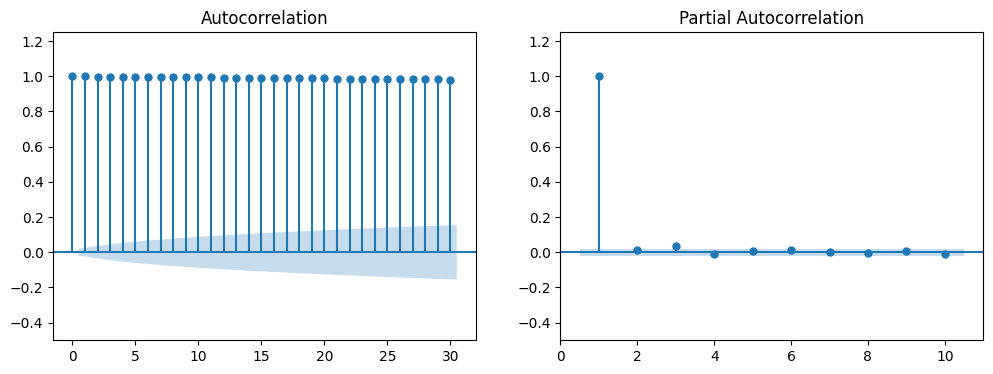

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

# ACF Plot
plot_acf(df['Low'], lags=30, ax=axes[0])
# PACF Plot
plot_pacf(df['Low'], lags=10, zero=False, ax=axes[1])

for ax in axes:
    ax.set_ylim(-0.5, 1.25)
plt.show()

- ACF의 경우 점차 감소하며 0에 수렴하는 형태를 보인다.
- PACF의 경우 시차 1 이후에 0이다.

> AR(1) 모형을 적용할 수 있다.

**ADF 검정**
- H0: 해당 시계열은 비정상(non-stationary) 시계열이다. <-> H1: 해당 시계열은 정상(stationary) 시계열이다.
  - p-value <= 0.05 : 귀무가설 기각/ 대립가설 채택 -> 정상(stationary) 시계열
  - p-value > 0.05 : 귀무가설 채택/ 대립가설 기각 -> 비정상(non-stationary) 시계열

In [ ]:
# Adfuller 테스트

adfuller_test(df['Low'], maxlag=30)

ADF: -1.13607
p-value: 0.70
Lags: 5
Number of Observations: 9402
검증결과: 비정상(non-stationary) 시계열 데이터입니다.


In [ ]:
# 1차 차분 후 검정

adfuller_test(df['Low'].diff(periods=1).iloc[1:], maxlag=30)

ADF: -46.23796
p-value: 0.00
Lags: 4
Number of Observations: 9402
검증결과: 정상(stationary) 시계열 데이터입니다.


### **b) 예측**

#### **ARIMA**

In [ ]:
# auto_arima를 사용하여 최적 모델 찾기

from pmdarima.arima import auto_arima

# m=0 : non-seasonal
low_arima = auto_arima(df['Low'],
                        test='adf', # 정상성 검정
                        trace=True,
                        error_action='ignore',
                        max_p = 5, max_q = 4,max_d = 3,
                        suppress_warnings=True,
                        stepwise=True,
                        seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=122299.322, Time=13.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=122370.568, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=122364.661, Time=0.91 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=122363.127, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=122371.225, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=122298.158, Time=3.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=122301.975, Time=3.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=122336.899, Time=6.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=122300.017, Time=11.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=122298.761, Time=1.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=122297.625, Time=1.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=122301.959, Time=1.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=122299.514, Time=6.76 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=122298.458, Time=1.20 sec
 AR

In [ ]:
low_arima.summary() # 좋은 결과라고 보긴 어렵다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9408
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -61143.812
Date:                Sat, 03 Feb 2024   AIC                         122297.625
Time:                        13:06:59   BIC                         122333.371
Sample:                    01-01-2023   HQIC                        122309.762
                         - 01-27-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9528      2.501      1.181      0.238      -1.949       7.855
ar.L1         -0.3228      0.072     -4.508      0.000      -0.463      -0.182
ar.L2         -0.0913      0.005    -17.043      0.000      -0.102      -0.081
ma.L1          0.2937      0.072      4.107      0.000       0.154       0.434
sigma2      2.591e+04     73.941    350.373      0.000    2.58e+04    2.61e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1716349.28
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -3.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
### 예측
# 미래에 대한 예측을 위한 기간 설정
future_periods = 73
future_dates = [df.index.max() + timedelta(hours=i) for i in range(1, future_periods + 1)]

# 최적 모델을 사용하여 예측 수행
pred_low = low_arima.predict(n_periods=future_periods)

# 예측 결과를 DataFrame으로 저장
pred_low_arima = pd.DataFrame({'Low': pred_low}, index=future_dates)
pred_low_arima

Low
2024-01-28 00:00:00  42054.938382
2024-01-28 01:00:00  42058.241106
2024-01-28 02:00:00  42060.169828
2024-01-28 03:00:00  42062.198269
2024-01-28 04:00:00  42064.320021
...                           ...
2024-01-30 20:00:00  42197.944928
2024-01-30 21:00:00  42200.032911
2024-01-30 22:00:00  42202.120895
2024-01-30 23:00:00  42204.208878
2024-01-31 00:00:00  42206.296862

[73 rows x 1 columns]

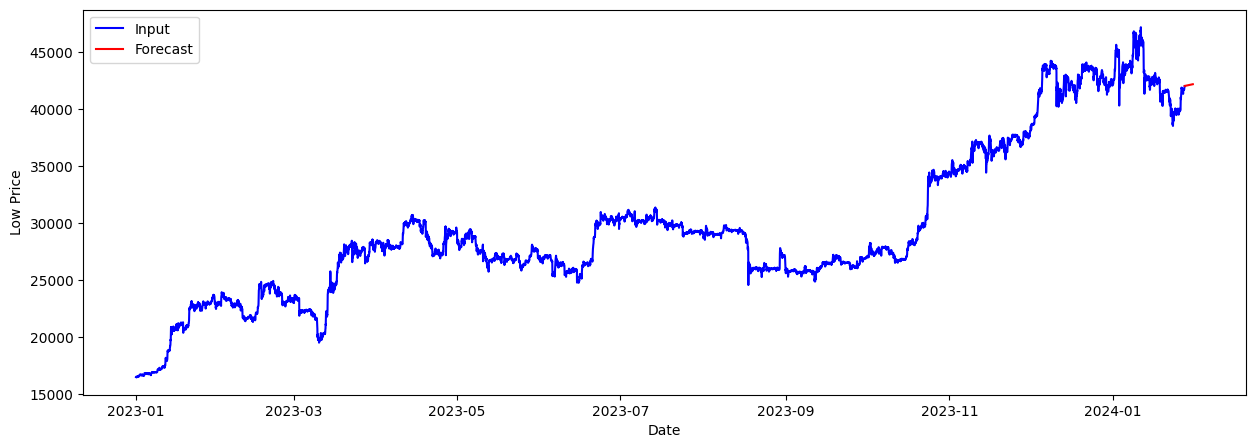

In [ ]:
### 시각화
plt.figure(figsize = (15, 5))

plt.plot(df['Low'], label='Input', color='blue')
plt.plot(pred_low_arima, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.legend()
plt.show()

#### **Prophet**

In [ ]:
# Prophet에 사용할 열만 선택 (ds: 시간, y: 예측 변수)

prophet_low = df[['Low']]
prophet_low['ds'] = df.index
prophet_low.columns = ['y', 'ds']
prophet_low

y                  ds
Time                                            
2023-01-01 00:00:00  16504.0 2023-01-01 00:00:00
2023-01-01 01:00:00  16524.1 2023-01-01 01:00:00
2023-01-01 02:00:00  16534.8 2023-01-01 02:00:00
2023-01-01 03:00:00  16515.0 2023-01-01 03:00:00
2023-01-01 04:00:00  16508.8 2023-01-01 04:00:00
...                      ...                 ...
2024-01-27 19:00:00  41775.1 2024-01-27 19:00:00
2024-01-27 20:00:00  41896.4 2024-01-27 20:00:00
2024-01-27 21:00:00  42001.8 2024-01-27 21:00:00
2024-01-27 22:00:00  42057.6 2024-01-27 22:00:00
2024-01-27 23:00:00  42055.4 2024-01-27 23:00:00

[9408 rows x 2 columns]

**기본 모델**

In [ ]:
# 로그 끄기

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [ ]:
# 모델 객체 생성
m_low = Prophet()
# 학습
m_low.fit(prophet_low)
# 예측
future = m_low.make_future_dataframe(periods = 73, freq='H')
forecast = m_low.predict(future)

In [ ]:
forecast.tail(73)[['ds', 'yhat']]

ds          yhat
9408 2024-01-28 00:00:00  44578.931634
9409 2024-01-28 01:00:00  44588.464385
9410 2024-01-28 02:00:00  44597.413710
9411 2024-01-28 03:00:00  44607.660068
9412 2024-01-28 04:00:00  44616.808809
...                  ...           ...
9476 2024-01-30 20:00:00  44859.827003
9477 2024-01-30 21:00:00  44873.567602
9478 2024-01-30 22:00:00  44890.762245
9479 2024-01-30 23:00:00  44907.975417
9480 2024-01-31 00:00:00  44921.718444

[73 rows x 2 columns]

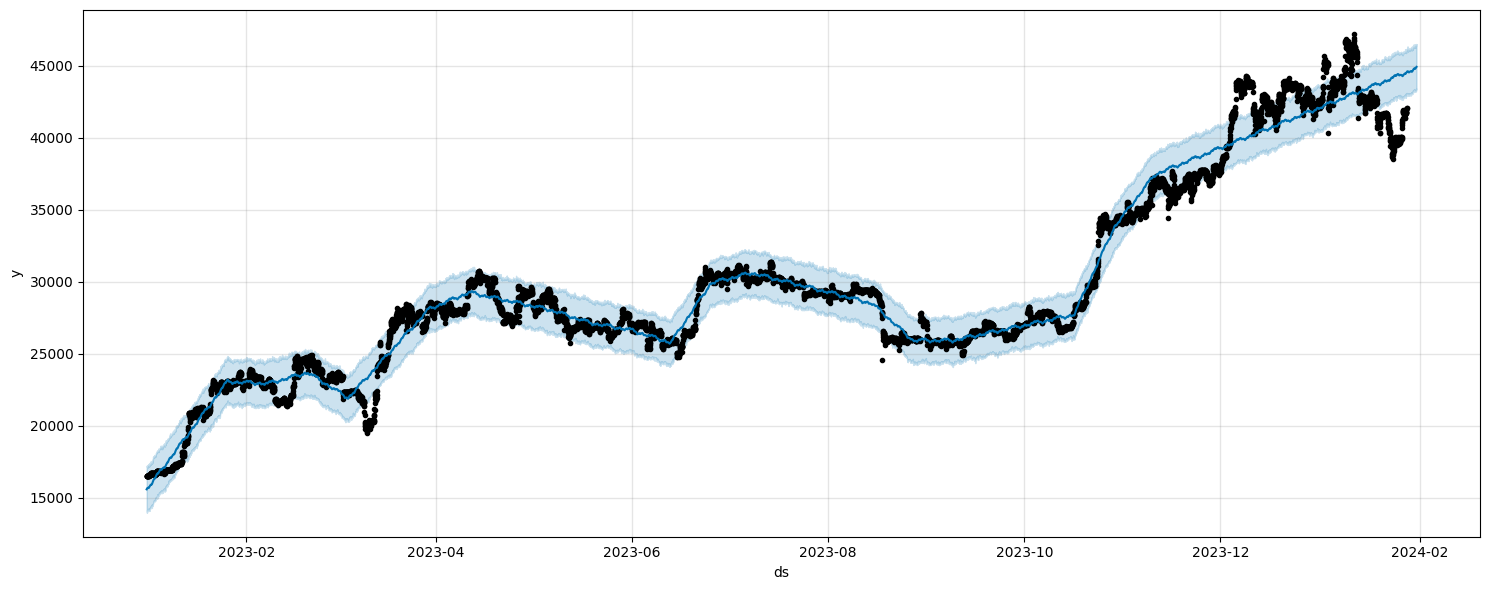

In [ ]:
### 시각화
fig = m_low.plot(forecast, figsize=(15, 6))

- 우상향 할 것이라고 예측하고 있다.

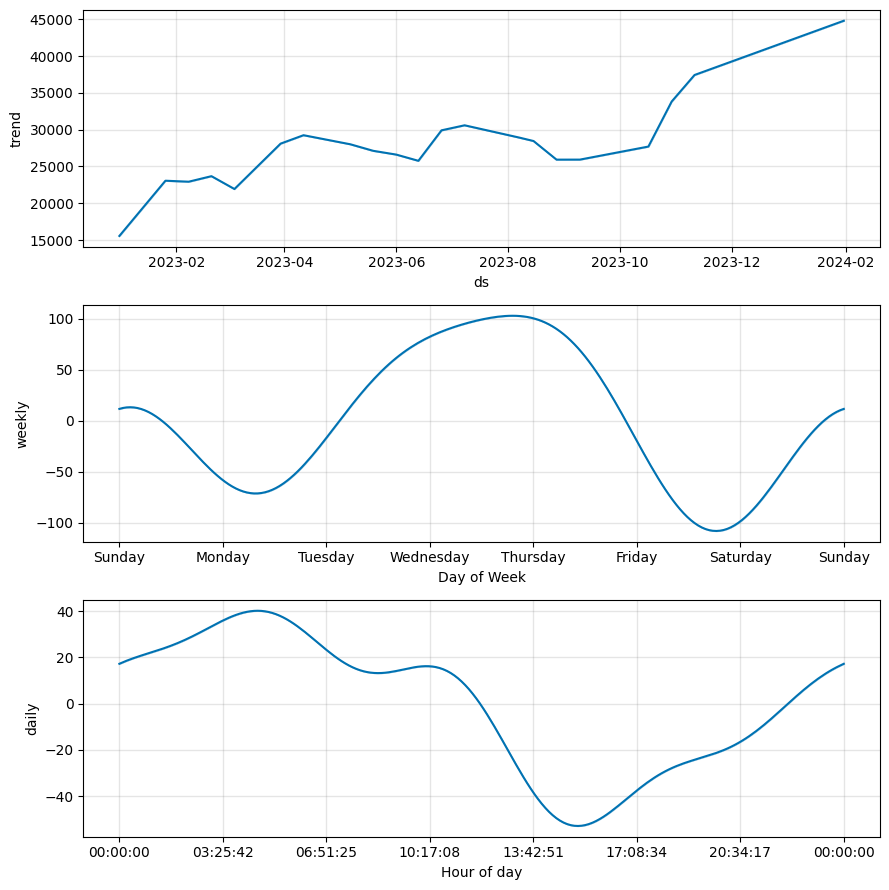

In [ ]:
### 컴포넌트 별 시각화

fig2 = m_low.plot_components(forecast)

- 우상향 추세를 보인다.
- 주간, 일간 계절성이 보인다.

**파라미터 튜닝**

In [ ]:
# 파라미터 그리드 정의
param_grid = {
    ## 추세
    'changepoint_prior_scale': [0.01, 0.05],  # 변곡점의 유연성
    ## 계절성
    'seasonality_mode': ['additive'],
    'yearly_seasonality': [False],  # 연간 계절성
    'weekly_seasonality': [True],  # 주간 계절성
    'daily_seasonality': [True],  # 일간 계절성
    'seasonality_prior_scale': [0.1, 1.0],  # 계절성의 유연성
     ## 휴일
    'holidays_prior_scale': [0.1, 1.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
best_params = None
best_rmse = float('inf')

# 파라미터 평가를 위해 cv 진행
for i, params in enumerate(all_params, 1):
  print(f"Parameter tuning iteration {i}/{len(all_params)}")

  m = Prophet(**params).fit(prophet_low)
  df_cv = cross_validation(m, initial='1000 hours', period='360 hours', horizon='73 hours', parallel="processes")
  df_p = performance_metrics(df_cv, rolling_window=1)
  rmse = df_p['rmse'].values[0]

  print(f"RMSE: {rmse}")
  print()

  if rmse < best_rmse:
    best_rmse = rmse
    best_params = params

print("\nBest parameters:")
print(best_params)

Parameter tuning iteration 1/8
RMSE: 2086.301201573347

Parameter tuning iteration 2/8
RMSE: 2086.301201573347

Parameter tuning iteration 3/8
RMSE: 2085.6833551719437

Parameter tuning iteration 4/8
RMSE: 2085.6833551719437

Parameter tuning iteration 5/8
RMSE: 2007.1593641281572

Parameter tuning iteration 6/8
RMSE: 2007.1593641281572

Parameter tuning iteration 7/8
RMSE: 2006.38608143718

Parameter tuning iteration 8/8
RMSE: 2006.38608143718


Best parameters:
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1}


In [ ]:
# 최적 모델로 fitting
low_prophet = Prophet(**best_params).fit(prophet_low)

# Make predictions
future = low_prophet.make_future_dataframe(periods=73, freq='H')
pred_low_prophet = low_prophet.predict(future)

In [ ]:
pred_low_prophet.tail(73)[['ds', 'yhat']]

ds          yhat
9408 2024-01-28 00:00:00  44584.680677
9409 2024-01-28 01:00:00  44594.217479
9410 2024-01-28 02:00:00  44603.170090
9411 2024-01-28 03:00:00  44613.419715
9412 2024-01-28 04:00:00  44622.571286
...                  ...           ...
9476 2024-01-30 20:00:00  44866.064146
9477 2024-01-30 21:00:00  44879.816736
9478 2024-01-30 22:00:00  44897.024250
9479 2024-01-30 23:00:00  44914.250068
9480 2024-01-31 00:00:00  44928.004316

[73 rows x 2 columns]

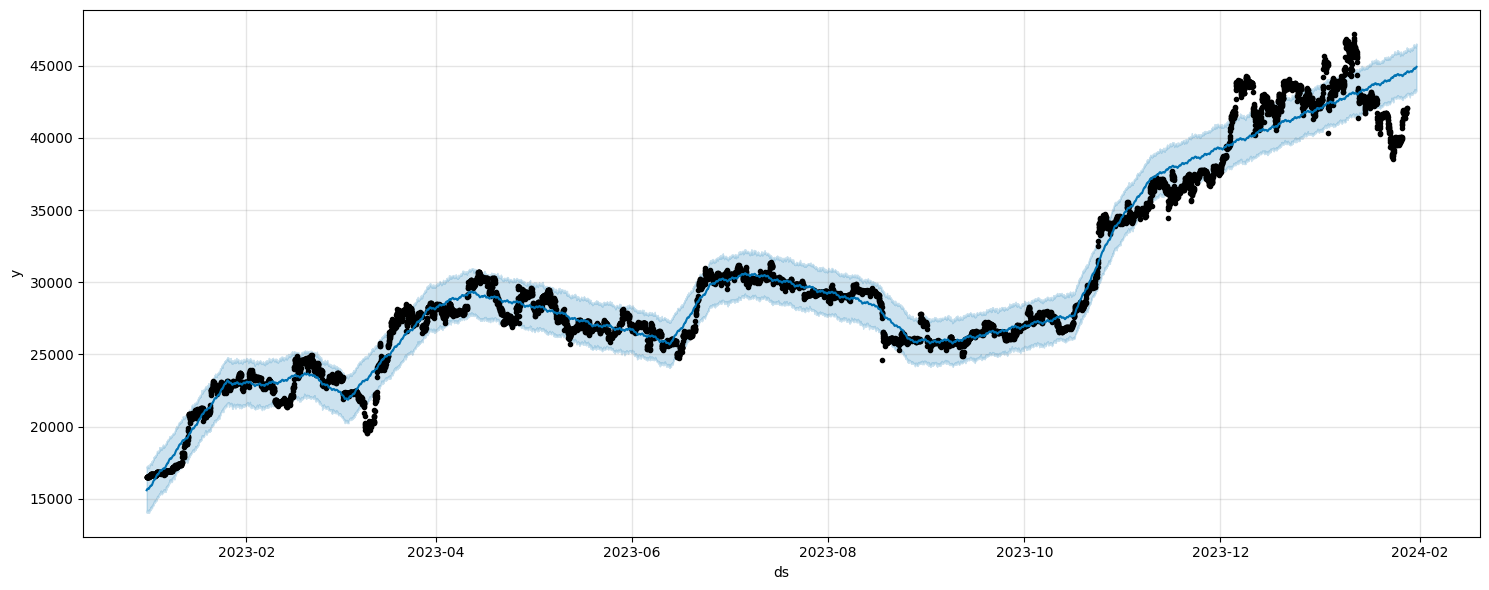

In [ ]:
### 시각화
fig3 = low_prophet.plot(pred_low_prophet, figsize=(15, 6))

#### **최종**
- 일정한 비율로 혼합하여 최종 예측값으로 채택

In [ ]:
pred_low_final = pred_low_arima['Low'].values * 0.4 + pred_low_prophet.tail(73)['yhat'] * 0.6
pred_low_final

9408    43572.783759
9409    43579.826930
9410    43585.969985
9411    43592.931136
9412    43599.270780
            ...     
9476    43798.816459
9477    43807.903206
9478    43819.062908
9479    43830.233592
9480    43839.321334
Name: yhat, Length: 73, dtype: float64

## **2-5. 종가(Close)**

### **a) 시계열 분석**

#### **시도표**

In [ ]:
fig = go.Figure()

# 시가 라인 플롯 추가
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Close', line=dict(color='green')))

# 레이아웃 설정
fig.update_layout(title_text="Close", title_x=0.5)

# 차트 출력
fig.show()

#### **시계열 분해**

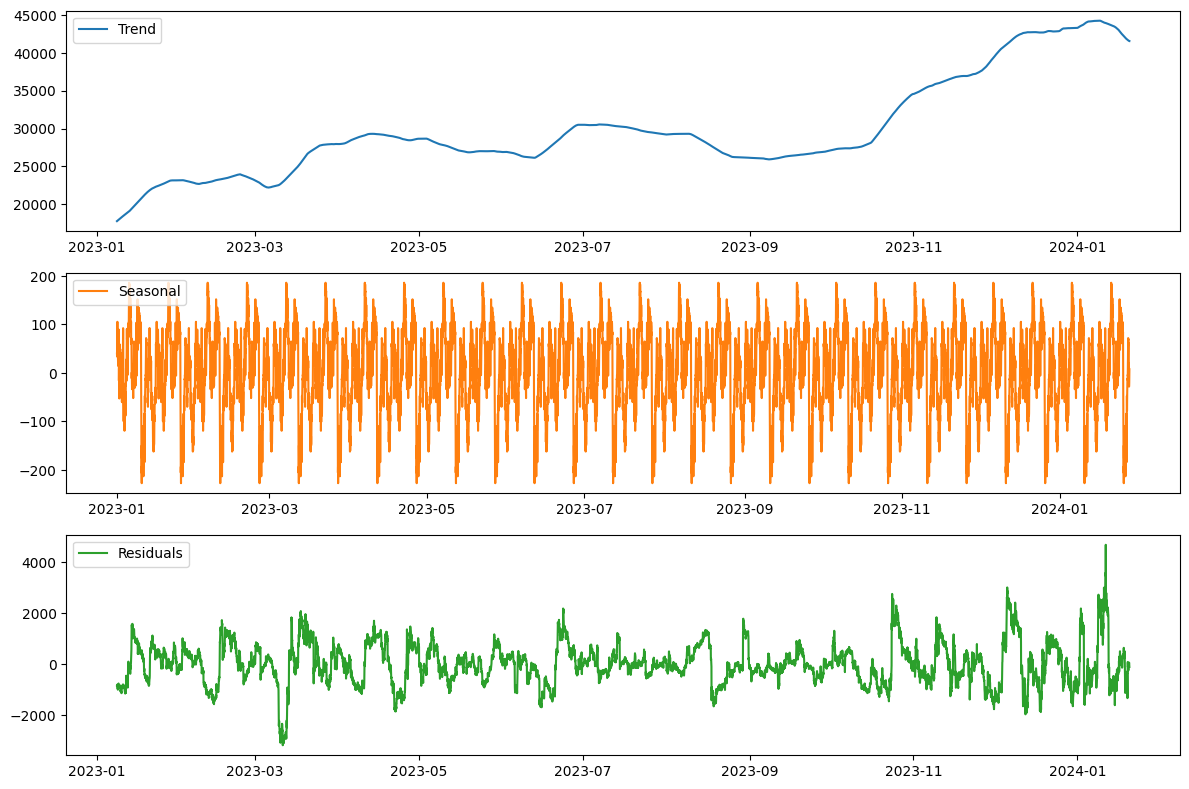

In [ ]:
## 시계열 분해
result = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)

# 색상 설정
colors = plt.cm.tab10.colors

## 시각화
plt.figure(figsize=(12, 8))

# 추세(Trend)
plt.subplot(3, 1, 1)
plt.plot(df.index, result.trend, label='Trend', color=colors[0])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 계절성(Seasonality)
plt.subplot(3, 1, 2)
plt.plot(df.index, result.seasonal, label='Seasonal', color=colors[1])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 잔차(Residuals) 분석
plt.subplot(3, 1, 3)
plt.plot(df.index, result.resid, label='Residuals', color=colors[2])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 레이아웃 조정
plt.tight_layout()

# 시각화 표시
plt.show()

- 추세(Trend)
  - 우상향 추세를 보인다.

- 계절성(Seasonality)
  - 월 단위로 계절적 주기성을 보인다.
- 잔차 분석
  - 잔차에 어떠한 패턴을 보이고 있지는 않다.

#### **정상성**

**ACF/PACF**

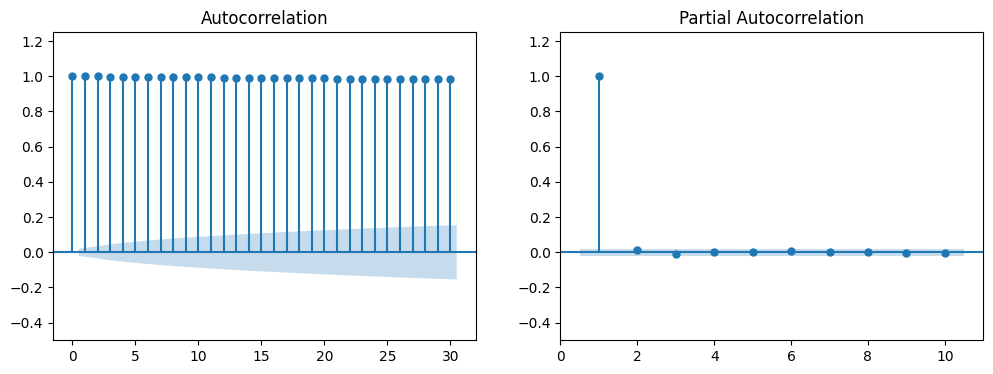

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

# ACF Plot
plot_acf(df['Close'], lags=30, ax=axes[0])
# PACF Plot
plot_pacf(df['Close'], lags=10, zero=False, ax=axes[1])

for ax in axes:
    ax.set_ylim(-0.5, 1.25)
plt.show()

- ACF의 경우 점차 감소하며 0에 수렴하는 형태를 보인다.
- PACF의 경우 시차 1 이후에 0이다.

> AR(1) 모형을 적용할 수 있다.

**ADF 검정**
- H0: 해당 시계열은 비정상(non-stationary) 시계열이다. <-> H1: 해당 시계열은 정상(stationary) 시계열이다.
  - p-value <= 0.05 : 귀무가설 기각/ 대립가설 채택 -> 정상(stationary) 시계열
  - p-value > 0.05 : 귀무가설 채택/ 대립가설 기각 -> 비정상(non-stationary) 시계열

In [ ]:
# Adfuller 테스트

adfuller_test(df['Close'], maxlag=30)

ADF: -1.17634
p-value: 0.68
Lags: 23
Number of Observations: 9384
검증결과: 비정상(non-stationary) 시계열 데이터입니다.


In [ ]:
# 1차 차분 후 검정

adfuller_test(df['Close'].diff(periods=1).iloc[1:], maxlag=30)

ADF: -17.96622
p-value: 0.00
Lags: 30
Number of Observations: 9376
검증결과: 정상(stationary) 시계열 데이터입니다.


### **b) 예측**

#### **ARIMA**

In [ ]:
# auto_arima를 사용하여 최적 모델 찾기

from pmdarima.arima import auto_arima

# m=0 : non-seasonal
close_arima = auto_arima(df['Close'],
                        test='adf', # 정상성 검정
                        trace=True,
                        error_action='ignore',
                        max_p = 5, max_q = 4,max_d = 3,
                        suppress_warnings=True,
                        stepwise=True,
                        seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=120209.861, Time=16.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=120223.105, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=120208.378, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120209.095, Time=1.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=120224.450, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=120206.187, Time=1.00 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=120207.941, Time=1.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=120207.974, Time=7.98 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=120206.809, Time=6.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=120209.922, Time=1.64 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=120207.675, Time=0.43 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 38.704 seconds


In [ ]:
close_arima.summary() # 좋은 결과라고 보긴 어렵다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9408
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -60099.094
Date:                Sat, 03 Feb 2024   AIC                         120206.187
Time:                        13:18:02   BIC                         120234.784
Sample:                    01-01-2023   HQIC                        120215.897
                         - 01-27-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.7725      1.492      1.859      0.063      -0.151       5.696
ar.L1         -0.0413      0.004     -9.493      0.000      -0.050      -0.033
ar.L2          0.0211      0.006      3.366      0.001       0.009       0.033
sigma2      2.074e+04     87.879    236.014      0.000    2.06e+04    2.09e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            195964.75
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
### 예측
# 미래에 대한 예측을 위한 기간 설정
future_periods = 73
future_dates = [df.index.max() + timedelta(hours=i) for i in range(1, future_periods + 1)]

# 최적 모델을 사용하여 예측 수행
pred_close = close_arima.predict(n_periods=future_periods)

# 예측 결과를 DataFrame으로 저장
pred_close_arima = pd.DataFrame({'Close': pred_close}, index=future_dates)
pred_close_arima

Close
2024-01-28 00:00:00  42106.285463
2024-01-28 01:00:00  42108.190631
2024-01-28 02:00:00  42110.970778
2024-01-28 03:00:00  42113.668795
2024-01-28 04:00:00  42116.388672
...                           ...
2024-01-30 20:00:00  42290.323948
2024-01-30 21:00:00  42293.041693
2024-01-30 22:00:00  42295.759439
2024-01-30 23:00:00  42298.477185
2024-01-31 00:00:00  42301.194930

[73 rows x 1 columns]

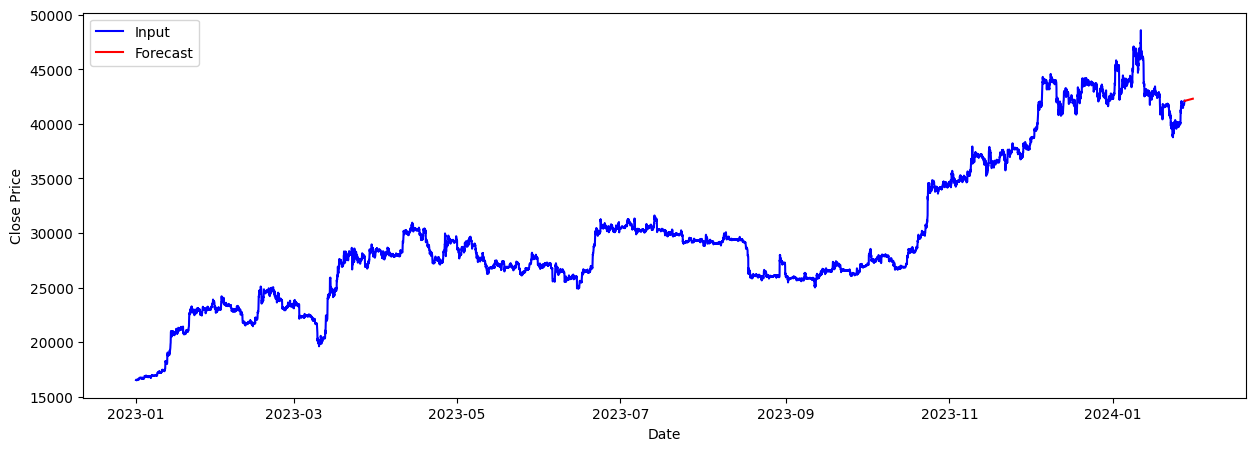

In [ ]:
### 시각화
plt.figure(figsize = (15, 5))

plt.plot(df['Close'], label='Input', color='blue')
plt.plot(pred_close_arima, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### **Prophet**

In [ ]:
# Prophet에 사용할 열만 선택 (ds: 시간, y: 예측 변수)

prophet_close = df[['Close']]
prophet_close['ds'] = df.index
prophet_close.columns = ['y', 'ds']
prophet_close

y                  ds
Time                                            
2023-01-01 00:00:00  16527.0 2023-01-01 00:00:00
2023-01-01 01:00:00  16550.4 2023-01-01 01:00:00
2023-01-01 02:00:00  16542.4 2023-01-01 02:00:00
2023-01-01 03:00:00  16529.3 2023-01-01 03:00:00
2023-01-01 04:00:00  16517.8 2023-01-01 04:00:00
...                      ...                 ...
2024-01-27 19:00:00  41896.4 2024-01-27 19:00:00
2024-01-27 20:00:00  42049.6 2024-01-27 20:00:00
2024-01-27 21:00:00  42137.8 2024-01-27 21:00:00
2024-01-27 22:00:00  42135.3 2024-01-27 22:00:00
2024-01-27 23:00:00  42102.2 2024-01-27 23:00:00

[9408 rows x 2 columns]

**기본 모델**

In [ ]:
# 로그 끄기

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [ ]:
# 모델 객체 생성
m_close = Prophet()
# 학습
m_close.fit(prophet_close)
# 예측
future = m_close.make_future_dataframe(periods = 73, freq='H')
forecast = m_close.predict(future)

In [ ]:
forecast.tail(73)[['ds', 'yhat']]

ds          yhat
9408 2024-01-28 00:00:00  44720.128392
9409 2024-01-28 01:00:00  44725.730789
9410 2024-01-28 02:00:00  44726.305277
9411 2024-01-28 03:00:00  44725.954867
9412 2024-01-28 04:00:00  44727.620136
...                  ...           ...
9476 2024-01-30 20:00:00  45078.026263
9477 2024-01-30 21:00:00  45086.063457
9478 2024-01-30 22:00:00  45098.378095
9479 2024-01-30 23:00:00  45113.233491
9480 2024-01-31 00:00:00  45125.695005

[73 rows x 2 columns]

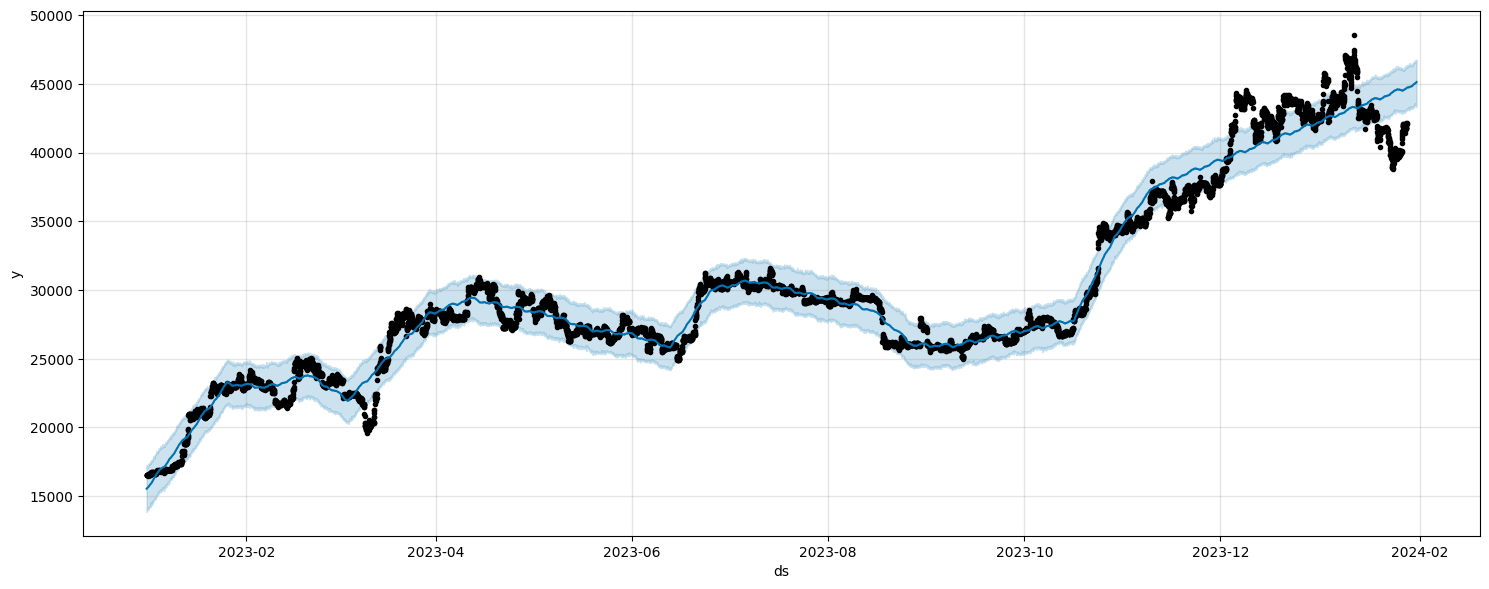

In [ ]:
### 시각화
fig = m_close.plot(forecast, figsize=(15, 6))

- 우상향 할 것이라고 예측하고 있다.

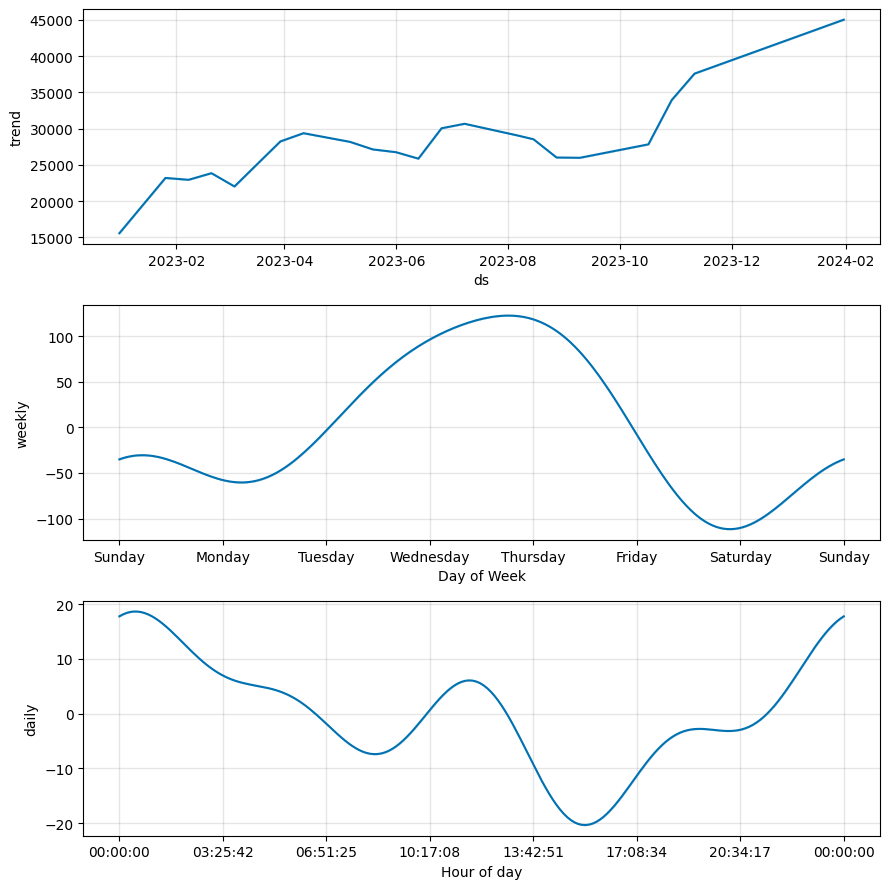

In [ ]:
### 컴포넌트 별 시각화

fig2 = m_close.plot_components(forecast)

- 우상향 추세를 보인다.
- 주간, 일간 계절성이 보인다.

**파라미터 튜닝**

In [ ]:
# 파라미터 그리드 정의
param_grid = {
    ## 추세
    'changepoint_prior_scale': [0.01, 0.05],  # 변곡점의 유연성
    ## 계절성
    'seasonality_mode': ['additive'],
    'yearly_seasonality': [False],  # 연간 계절성
    'weekly_seasonality': [True],  # 주간 계절성
    'daily_seasonality': [True],  # 일간 계절성
    'seasonality_prior_scale': [0.1, 1.0],  # 계절성의 유연성
     ## 휴일
    'holidays_prior_scale': [0.1, 1.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
best_params = None
best_rmse = float('inf')

# 파라미터 평가를 위해 cv 진행
for i, params in enumerate(all_params, 1):
  print(f"Parameter tuning iteration {i}/{len(all_params)}")

  m = Prophet(**params).fit(prophet_close)
  df_cv = cross_validation(m, initial='1000 hours', period='360 hours', horizon='73 hours', parallel="processes")
  df_p = performance_metrics(df_cv, rolling_window=1)
  rmse = df_p['rmse'].values[0]

  print(f"RMSE: {rmse}")
  print()

  if rmse < best_rmse:
    best_rmse = rmse
    best_params = params

print("\nBest parameters:")
print(best_params)

Parameter tuning iteration 1/8
RMSE: 2095.9983055707944

Parameter tuning iteration 2/8
RMSE: 2095.9983055707944

Parameter tuning iteration 3/8
RMSE: 2100.5877218583582

Parameter tuning iteration 4/8
RMSE: 2100.5877218583582

Parameter tuning iteration 5/8
RMSE: 2011.6184037647197

Parameter tuning iteration 6/8
RMSE: 2011.6184037647197

Parameter tuning iteration 7/8
RMSE: 2011.3520434986779

Parameter tuning iteration 8/8
RMSE: 2011.3520434986779


Best parameters:
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1}


In [ ]:
# 최적 모델로 fitting
close_prophet = Prophet(**best_params).fit(prophet_close)

# Make predictions
future = close_prophet.make_future_dataframe(periods=73, freq='H')
pred_close_prophet = close_prophet.predict(future)

In [ ]:
pred_close_prophet.tail(73)[['ds', 'yhat']]

ds          yhat
9408 2024-01-28 00:00:00  44723.279806
9409 2024-01-28 01:00:00  44728.885107
9410 2024-01-28 02:00:00  44729.465870
9411 2024-01-28 03:00:00  44729.125043
9412 2024-01-28 04:00:00  44730.801168
...                  ...           ...
9476 2024-01-30 20:00:00  45081.716923
9477 2024-01-30 21:00:00  45089.769698
9478 2024-01-30 22:00:00  45102.098434
9479 2024-01-30 23:00:00  45116.965796
9480 2024-01-31 00:00:00  45129.438149

[73 rows x 2 columns]

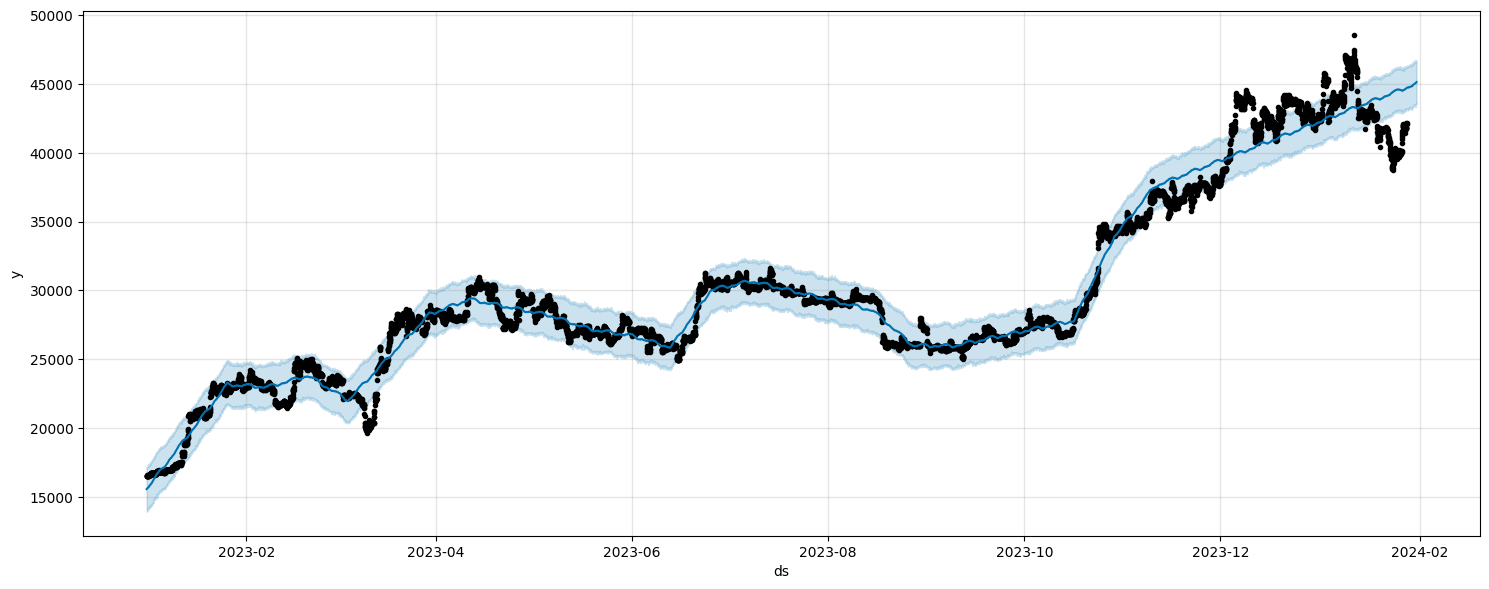

In [ ]:
### 시각화
fig3 = close_prophet.plot(pred_close_prophet, figsize=(15, 6))

#### **최종**
- 일정한 비율로 혼합하여 최종 예측값으로 채택

In [ ]:
pred_close_final = pred_close_arima['Close'].values * 0.4 + pred_close_prophet.tail(73)['yhat'] * 0.6
pred_close_final

9408    43676.482068
9409    43680.607316
9410    43682.067833
9411    43682.942544
9412    43685.036170
            ...     
9476    43965.159733
9477    43971.078496
9478    43979.562836
9479    43989.570352
9480    43998.140862
Name: yhat, Length: 73, dtype: float64

## **2-6. 거래량(Volume)**

### **a) 시계열 분석**

#### **시도표**

In [ ]:
fig = go.Figure()

# 거래량 라인 플롯 추가
fig.add_trace(go.Scatter(x=df.index, y=df['Volume'], mode='lines', name='Volume', line=dict(color='purple')))

# 레이아웃 설정
fig.update_layout(title_text="Volume", title_x=0.5)

# 차트 출력
fig.show()

#### **시계열 분해**

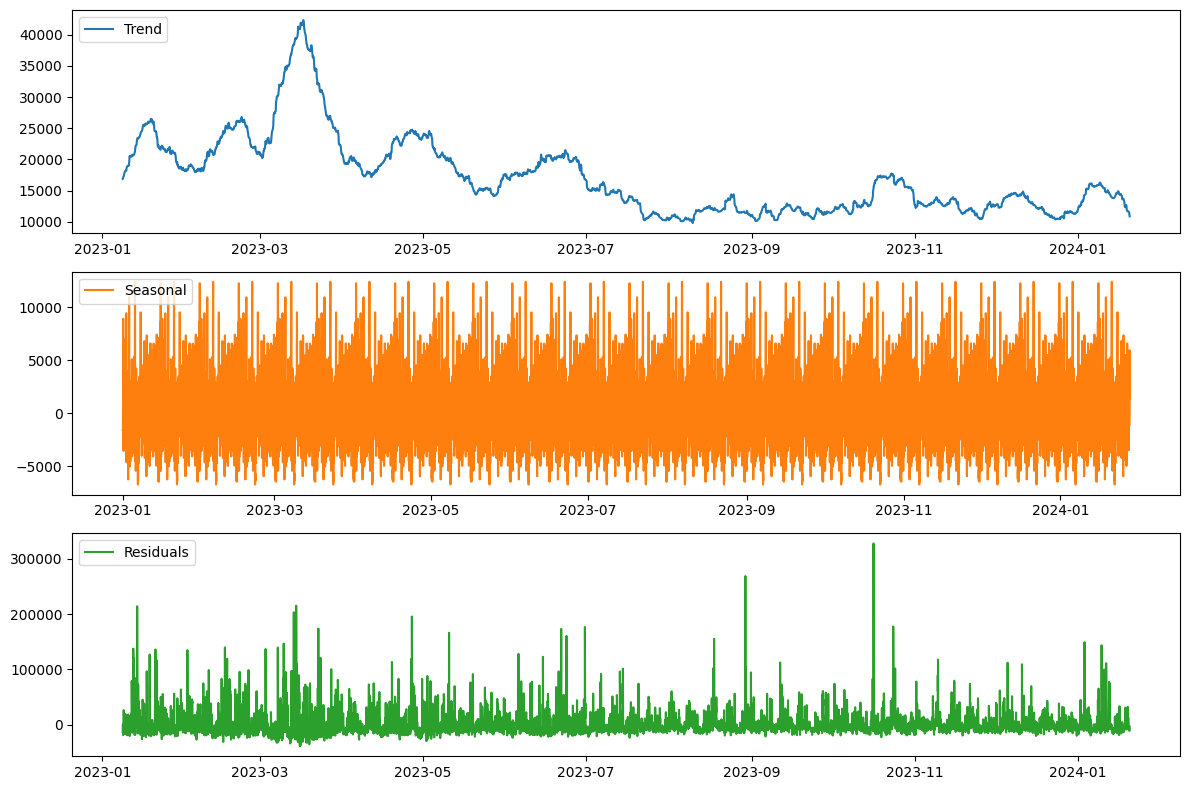

In [ ]:
## 시계열 분해
result = sm.tsa.seasonal_decompose(df['Volume'], model='additive', period=365)

# 색상 설정
colors = plt.cm.tab10.colors

## 시각화
plt.figure(figsize=(12, 8))

# 추세(Trend)
plt.subplot(3, 1, 1)
plt.plot(df.index, result.trend, label='Trend', color=colors[0])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 계절성(Seasonality)
plt.subplot(3, 1, 2)
plt.plot(df.index, result.seasonal, label='Seasonal', color=colors[1])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 잔차(Residuals) 분석
plt.subplot(3, 1, 3)
plt.plot(df.index, result.resid, label='Residuals', color=colors[2])  # x축을 df.index로 변경
plt.legend(loc='upper left')

# 레이아웃 조정
plt.tight_layout()

# 시각화 표시
plt.show()

- 추세나 계절성, 주기성을 보이지 않는다.
- 다만, 2023-04에 거래량이 급증한 것을 확인할 순 있다.

#### **최종**
- 거래량의 경우 시계열적인 특징을 지니고 있지 않다고 판단됨
  - 2024/01의 시간별 평균값으로 예측

In [ ]:
hourly_mean = df.loc[df.index >= '2024-01-01'].groupby(df.loc[df.index >= '2024-01-01'].index.hour)['Volume'].mean().values
hourly_mean

array([11886.49025926, 10068.74537037,  7363.99455556,  7193.95385185,
        5881.50540741,  5978.4012963 ,  7361.04981481,  8630.42822222,
        9074.78948148, 11029.32277778, 10990.48037037, 14511.72922222,
       21737.6127037 , 14356.8587037 , 24484.97859259, 24632.21259259,
       22978.77651852, 16188.73425926, 18916.64066667, 15621.60177778,
       19421.92944444, 18044.55177778, 12967.15507407, 11534.68474074])

In [ ]:
pred_volume_final = pd.concat([pd.Series(hourly_mean)] * 3, ignore_index=True)
pred_volume_final = pd.concat([pred_volume_final,pd.Series(hourly_mean[0])], ignore_index=True)
pred_volume_final

0     11886.490259
1     10068.745370
2      7363.994556
3      7193.953852
4      5881.505407
          ...     
68    19421.929444
69    18044.551778
70    12967.155074
71    11534.684741
72    11886.490259
Length: 73, dtype: float64

## **2-7. 예측값 병합**

In [ ]:
date_rng = pd.date_range('2024-01-28 0:00:00', '2024-01-31 0:00:00', freq='H')

test = pd.DataFrame({
    'Time': date_rng,
    'Open': pred_open_final.to_numpy(),
    'High': pred_high_final.to_numpy(),
    'Low': pred_low_final.to_numpy(),
    'Close': pred_close_final.to_numpy(),
    'Volume': pred_volume_final
})

test['Time'] = pd.to_datetime(test['Time'])
test.set_index('Time', inplace=True)

test

Open          High           Low         Close  \
Time                                                                          
2024-01-28 00:00:00  43687.889385  43774.443251  43572.783759  43676.482068   
2024-01-28 01:00:00  43695.494754  43778.816738  43579.826930  43680.607316   
2024-01-28 02:00:00  43698.990073  43776.451039  43585.969985  43682.067833   
2024-01-28 03:00:00  43699.553413  43770.121091  43592.931136  43682.942544   
2024-01-28 04:00:00  43700.158038  43766.070468  43599.270780  43685.036170   
...                           ...           ...           ...           ...   
2024-01-30 20:00:00  43975.392978  44104.956888  43798.816459  43965.159733   
2024-01-30 21:00:00  43980.716139  44108.547144  43807.903206  43971.078496   
2024-01-30 22:00:00  43987.431616  44113.568381  43819.062908  43979.562836   
2024-01-30 23:00:00  43996.878269  44121.907283  43830.233592  43989.570352   
2024-01-31 00:00:00  44007.324551  44131.115451  43839.321334  43998.140862   

                           Volume  
Time                               
2024-01-28 00:00:00  11886.490259  
2024-01-28 01:00:00  10068.745370  
2024-01-28 02:00:00   7363.994556  
2024-01-28 03:00:00   7193.953852  
2024-01-28 04:00:00   5881.505407  
...                           ...  
2024-01-30 20:00:00  19421.929444  
2024-01-30 21:00:00  18044.551778  
2024-01-30 22:00:00  12967.155074  
2024-01-30 23:00:00  11534.684741  
2024-01-31 00:00:00  11886.490259  

[73 rows x 5 columns]

# **3. 기술적 지표 생성**
- 활용 가능한 지표를 모두 추가
  - 이후 Feature Selection을 통해 최종 Feature 선택
- 기술적 지표 계산 시 windowing 적용을 위해 일단은 train과 test 데이터를 concat 후 계산

In [ ]:
data = pd.concat([df, test], axis = 0)
data

Open          High           Low         Close  \
Time                                                                          
2023-01-01 00:00:00  16537.500000  16540.900000  16504.000000  16527.000000   
2023-01-01 01:00:00  16527.100000  16554.300000  16524.100000  16550.400000   
2023-01-01 02:00:00  16550.500000  16557.100000  16534.800000  16542.400000   
2023-01-01 03:00:00  16542.500000  16542.500000  16515.000000  16529.300000   
2023-01-01 04:00:00  16529.200000  16530.400000  16508.800000  16517.800000   
...                           ...           ...           ...           ...   
2024-01-30 20:00:00  43975.392978  44104.956888  43798.816459  43965.159733   
2024-01-30 21:00:00  43980.716139  44108.547144  43807.903206  43971.078496   
2024-01-30 22:00:00  43987.431616  44113.568381  43819.062908  43979.562836   
2024-01-30 23:00:00  43996.878269  44121.907283  43830.233592  43989.570352   
2024-01-31 00:00:00  44007.324551  44131.115451  43839.321334  43998.140862   

                           Volume  
Time                               
2023-01-01 00:00:00   5381.399000  
2023-01-01 01:00:00   3210.826000  
2023-01-01 02:00:00   2399.668000  
2023-01-01 03:00:00   3214.480000  
2023-01-01 04:00:00   3150.954000  
...                           ...  
2024-01-30 20:00:00  19421.929444  
2024-01-30 21:00:00  18044.551778  
2024-01-30 22:00:00  12967.155074  
2024-01-30 23:00:00  11534.684741  
2024-01-31 00:00:00  11886.490259  

[9481 rows x 5 columns]

In [ ]:
# !pip install ta

In [ ]:
import ta

H, L, C, V = data['High'], data['Low'], data['Close'], data['Volume']

## **3-1. 변동성 지표**

**1. 볼린저 밴드(BB: Bollinger Bands)**  
- 주가의 표준 편차를 이용하여 상한선과 하한선을 계산하는 기술적 분석 지표

**2. 애버리지 트루 레인지(ATR: Average True Range)**  
- 시장 변동성을 측정하고, 트레이더가 적절한 손절 레벨과 포지션 크기를 결정하는 데 널리 사용되는 기술 분석 지표

**3. 켈트너 채널(Keltner Channel)**  
- 채널과 관련된 가격 행동을 분석하여 추세의 강도와 방향을 평가하는 지표

**4. 돈치안 채널(Donchian Channel)**
- 가격 행동을 채널과 관련하여 분석하여 돌파 및 반전을 파악하는 데 도움이 되는 지표

**5. Ulcer Index(UI)**
- 투자 포트폴리오의 가격 움직임에 대한 정보를 제공하여 리스크를 평가하는 데 도움이 되는 지표

In [ ]:
### 볼린저 밴드
data['BHB'] = ta.volatility.bollinger_hband(close = C, fillna = True)
data['BLB'] = ta.volatility.bollinger_lband(close = C, fillna = True)

### ATR
data['ATR'] = ta.volatility.average_true_range(high = H, low = L, close = C, fillna = True)

### 켈트너 채널
data['KCH'] = ta.volatility.keltner_channel_hband(high=H, low=L, close=C, fillna = True)
data['KCL'] = ta.volatility.keltner_channel_lband(high=H, low=L, close=C, fillna = True)
data['KCM'] = ta.volatility.keltner_channel_mband(high=H, low=L, close=C, fillna = True)

### 돈치안 채널
data['DCH'] = ta.volatility.donchian_channel_hband(high=H, low=L, close=C, fillna = True)
data['DCL'] = ta.volatility.donchian_channel_lband(high=H, low=L, close=C, fillna = True)
data['DCM'] = ta.volatility.donchian_channel_mband(high=H, low=L, close=C, fillna = True)

### UI
data['UI'] = ta.volatility.ulcer_index(close = C, fillna = True)

## **3-2. 추세 지표**


**1. 단순 이동 평균(Simple Moving Average, SMA)**
- 최근 n개의 종가를 단순 평균한 값

**2. 가중 이동 평균(Weighted Moving Average, WMA)**
- 최근 가격에 가중치（사용자가 설정 가능）를 부여하여 이동 평균 계산

**3. 지수 이동 평균(Exponential Moving Average, EMA)**  
- 최근 가격에 더 많은 가중치（지수 평활 계수 이용、 즉 이동 평균의 가중치가 지수적으로 줄어듦）를 부여하여 이동 평균을 계산

**4. 이동평균 수렴 확산 지수(Moving Average Convergence/Divergence, MACD)**  
- 서로 다른 이동평균선 사이의 관계에서 추세변화의 신호를 찾아 추세 방향과 주가 움직임을 분석하는 지표

**5. 평균 방향 지수(Average Directional Index, ADX)**
- 추세의 강도를 측정하기 위해서 사용
- 보통 ADX가 25 이상일 때 추세가 강하고, 20 이하일 때 추세가 약하다고 판단

**6.음의 보텍스 지표(Negative Vortex Indicator)/ 7. 양의 보텍스 지표(Positive Vortex Indicator)**
- 주식이나 다른 자산의 하락/상승 추세 강도 측정하기 위해 사용
- 0~100사이의 값을 가지고 값이 높을수록 일반적으로 하락/상승 추세 강도 강함

**8. Triple Exponential Average(TRIX)**
- 주식이나 다른 자산의 추세 반전을 파악하기 위해 사용
- 지수 평활 이동 평균(EMA)을 사용하여 가격 데이터의 변동을 분석하여 주로 추세 반전 신호를 포착하는 데 사용

**9. 매스 지수(Mass Index)**
- 고가와 저가의 차이를 이용하여 가격의 진동성을 측정

**10. Commodity Channel Index(CCI)**
- 주식이나 다른 자산의 과매수 및 과매도 상태를 파악하기 위해 사용
- 가격의 평균 변동성을 측정하여 과매수 및 과매도 상태를 식별하는 데 사용

**11. Detrended Price Oscillator(DPO)**
- 주식이나 다른 자산의 추세에서 추세를 제거한 가격을 분석하는 지표
- 가격 데이터에서 지수 이동 평균(EMA)을 사용하여 추세를 제거한 값을 계산

**12. Know Sure Thing(KST)**
- 4개의 이동평균선을 가중치 부여하여 합산한 값
- 장기 분석을 통해 종합적인 추세의 방향을 제시하는 면에서 유용한 지표

**13. 일목균형표(Ichimoku)**
- 전환선, 기준선, 선행스팬 A, 선행스팬 B,지표 스팬으로 이루어짐
- 선행 스팬 A란 기간 중 평균 고점과 저점을 활용하여 측정한 전환과 기준선의 평균을 나타냄

In [ ]:
### 단순이동평균
data['SMA'] = ta.trend.sma_indicator(close=C,fillna = True)
### 지수이동평균
data['EMA'] = ta.trend.ema_indicator(close=C, fillna = True)
### 가중이동평균
data['WMA'] = ta.trend.wma_indicator(close=C, fillna = True)

### 이동평균수렴확산지수
data['MACD'] = ta.trend.macd(close=C, fillna = True)

### 평균확산지수
data['ADX'] = ta.trend.adx(high=H, low=L, close=C, fillna = True)

### 음의 보텍스 지표
data['-VI'] = ta.trend.vortex_indicator_neg(high=H, low=L, close=C, fillna = True)

### 양의 보텍스 지표
data['+VI'] = ta.trend.vortex_indicator_pos(high=H, low=L, close=C, fillna = True)

### Triple Exponential Average
data['TRIX'] = ta.trend.trix(close=C, fillna = True)

### 매스 지수
data['MI'] = ta.trend.mass_index(high=H, low=L, fillna = True)

### Commodity Channel Index
data['CCI'] = ta.trend.cci(high=H, low=L, close=C, fillna = True)

### Detrended Price Oscillator
data['DPO'] = ta.trend.dpo(close=C, fillna = True)

###  Know Sure Thing
data['KST'] = ta.trend.kst(close=C, fillna = True)

### 일목균형표
data['Ichimoku'] = ta.trend.ichimoku_a(high=H, low=L, fillna = True)

## **3-3. 모멘텀 지표**


**1. 상대강도지수(RSI)**  
- 금융 상품의 가격 움직임의 속도와 규모를 측정하기 위해 사용되는 지표

**2. 스토캐스틱 RSI(SRSI)**
- RSI의 움직임을 추적하고 주가의 상대적인 강도 측정하는 데 사용됨
- 0~1사이의 값으로 1에 가까울수록 주가의 강도가 강함

**3. True Strength Index(TSI)**  
- 추세 방향과 과매수/과매도 상태 나타내기 위해 금융 시장 분석에 사용되는 기술 지표
- 상승과 하락 강도를 한번에 적용한 momentum 지표

**4. Ultimate Oscillator(UO)**
- 매수 압력의 단기, 중기, 장기 평균을 모두 고려하여 현재 시장의 매수 압력의 정도를 측정하는 모멘텀 지표

**5. Stochastic Oscillator(SR)**
- 가격 변화율의 상대적인 강도를 나타내는 지표

**6. Williams %R 지표(WR)**
- 주식의 과매수 및 과매도 상태를 확인하는 데 도움이 되는 지표


**7. Awesome Oscillator(AO)**
- 단기 및 중기 이동 평균선 간의 차이를 나타내어 주식의 추세 강도와 전환점 파악


**8. 카우프만 적응이동평균(Kaufman's Adaptive Moving Average, KAMA)**
- 가격 움직임뿐만 아니라 시장 변동성도 고려한 이동평균
- 사소하고 일시적인 가격 급등락인 ‘시장 노이즈’ 걸러낼 수 있음

**9. 변동률 지표(Rate of Change,ROC)**
- 현재 가격이 이전 가격에 대해 얼마나 변동했는지를 백분율로 표현한 값
- 주식의 가격 변동성을 측정하는 데 사용됨

**10. Price Percentage Oscillator(PPO)**
- 이동 평균선 간의 백분율 차이를 계산하여 추세의 강도와 전환점 평가

**11. Volume Percentage Oscillator(PVO)**
- 거래량의 이동 평균선 간의 백분율 차이를 계산하여 거래량의 추세와 전환점 평가하는 데 사용됨

In [ ]:
### 상대강도지수
data['RSI'] = ta.momentum.rsi(close=C, fillna = True)

### 스토캐스틱 RSI
data['SRSI'] = ta.momentum.stochrsi(close=C, fillna = True)

### True Strength Index
data['TSI'] = ta.momentum.tsi(close=C, fillna = True)

### Ultimate Oscillator
data['UO'] = ta.momentum.ultimate_oscillator(high=H, low=L, close=C, fillna = True)

### Stochastic Oscillator
data['SR'] = ta.momentum.stoch(close=C, high=H, low=L, fillna = True)

### Williams %R 지표
data['WR'] = ta.momentum.williams_r(high=H, low=L, close=C, fillna = True)

### Awesome Oscillator
data['AO'] = ta.momentum.awesome_oscillator(high=H, low=L, fillna = True)

### 카우프만 적응이동평균
data['KAMA'] = ta.momentum.kama(close=C, fillna = True)

### 변동률 지표
data['ROC'] = ta.momentum.roc(close=C, fillna = True)

### Price Percentage Oscillator
data['PPO'] = ta.momentum.ppo(close=C, fillna = True)

###  Volume Percentage Oscillator
data['PVO'] = ta.momentum.pvo(volume=V, fillna = True)

## **3-4. 거래량 지표**

**1. Money Flow Index(MFI)**
- 주식의 매수 압력과 매도 압력 측정하여 과매수 및 과매도 상태 파악하는 데 사용되는 기술적 분석 지표
- 80 이상 과매수 상태, 20이상 과매도 상태를 의미

**2. Accumulation/Distribution Index(ADI)**
- 주식의 고가(High), 저가(Low), 종가(Close), 거래량(Volume)을 기반으로 한 누적 분산 지수
- 거래량과 주가의 관계를 분석하여 매수자와 매도자 간의 균형을 측정하는 지표

**3. On-Balance Volume(OBV)**
- 주식의 가격 움직임과 거래량의 관계를 분석하여 매수 압력과 매도 압력을 측정하는 지표

**4. Chaikin Money Flow(CMF)**
- 주식의 가격 움직임과 거래량의 관계를 분석하여 매수 압력과 매도 압력을 측정하는 지표
- 주식의 가격 움직임에 따라 거래량이 어떻게 분배되는지를 나타내며, 주가와 거래량의 일치 또는 불일치를 판단하는 데 사용

**5. Force Index(FI)**
- 주식의 가격 움직임과 거래량의 관계를 분석하여 강세와 약세를 파악하는 지표
- 현재 주가의 변동폭과 거래량의 크기를 비교하여 매수 압력과 매도 압력을 측정, 일반적으로 힘 지표가 양수인 경우 상승 추세, 음수인 경우 하락 추세를 의미

**6. Ease of Movement(EOM_EMV)**
- 주식의 가격 움직임과 거래량의 관계를 분석하여 주가 움직임의 상대적인 쉬움을 측정하는 지표
- 주식의 가격 움직임을 거래량으로 나눈 값을 사용하여 계산되고 이를 통해 주가 움직임이 상대적으로 쉬웠는지 또는 어려웠는지 판단 가능

**7. Volume Price Trend(VPT)**
- 거래량의 변화율과 주가의 움직임을 조합하여 **주가의 추세**를 파악하는 지표

**8. Negative Volume Index(NVI)**
- 거래량이 감소할 때 움직이는 ‘스마트 머니’(전문 투자자, 거대 업체)의 추세를 파악

**9. Volume Weighted Average Price(VWAP)**
- 거래량을 고려한 평균 가격으로, 개별 거래의 가격과 거래량을 가중 평균하여 계산





In [ ]:
### Money Flow Index
data['MFI'] = ta.volume.money_flow_index(high=H, low=L, close=C, volume=V, fillna = True)

### Accumulation/Distribution Index
data['ADI'] = ta.volume.acc_dist_index(high=H, low=L, close=C, volume=V, fillna = True)

### On-Balance Volume
data['OBV'] = ta.volume.on_balance_volume(close=C, volume=V, fillna = True)

### Chaikin Money Flow
data['CMF'] = ta.volume.chaikin_money_flow(high=H, low=L, close=C, volume=V, fillna = True)

### Force Index
data['FI'] = ta.volume.force_index(close=C, volume=V, fillna = True)

### Ease of Movement
data['EOM_EMV'] = ta.volume.ease_of_movement(high=H, low=L, volume=V, fillna = True)

### Volume Price Trend
data['VPT'] = ta.volume.volume_price_trend(close=C, volume=V, fillna = True)

### Negative Volume Index
data['NVI'] = ta.volume.negative_volume_index(close=C, volume=V, fillna = True)

### Volume Weighted Average Price
data['VMAP'] = ta.volume.volume_weighted_average_price(high=H, low=L, close=C, volume=V, fillna = True)

## **3-5. 최종 변수 확인**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9481 entries, 2023-01-01 00:00:00 to 2024-01-31 00:00:00
Data columns (total 48 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      9481 non-null   float64
 1   High      9481 non-null   float64
 2   Low       9481 non-null   float64
 3   Close     9481 non-null   float64
 4   Volume    9481 non-null   float64
 5   BHB       9481 non-null   float64
 6   BLB       9481 non-null   float64
 7   ATR       9481 non-null   float64
 8   KCH       9481 non-null   float64
 9   KCL       9481 non-null   float64
 10  KCM       9481 non-null   float64
 11  DCH       9481 non-null   float64
 12  DCL       9481 non-null   float64
 13  DCM       9481 non-null   float64
 14  UI        9481 non-null   float64
 15  SMA       9481 non-null   float64
 16  EMA       9481 non-null   float64
 17  WMA       9481 non-null   float64
 18  MACD      9481 non-null   float64
 19  ADX       9481 non-null   float64

In [ ]:
### train과 test 분리

train = data[:-73]
test = data[-73:]

# **4. 변동성 계산**

In [ ]:
def calculate_volatility(data, window=20):
    # 일일 수익률 계산
    data['returns'] = data['Close'].pct_change()

    # 변동성 계산
    data['volatility'] = data['returns'].rolling(window=window).std()

    return data

In [ ]:
train = calculate_volatility(train)

In [ ]:
# 결측이 있는 행 삭제
train = train.dropna()

# return 열 삭제
train.drop('returns', axis = 1,inplace = True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9388 entries, 2023-01-01 20:00:00 to 2024-01-27 23:00:00
Data columns (total 49 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        9388 non-null   float64
 1   High        9388 non-null   float64
 2   Low         9388 non-null   float64
 3   Close       9388 non-null   float64
 4   Volume      9388 non-null   float64
 5   BHB         9388 non-null   float64
 6   BLB         9388 non-null   float64
 7   ATR         9388 non-null   float64
 8   KCH         9388 non-null   float64
 9   KCL         9388 non-null   float64
 10  KCM         9388 non-null   float64
 11  DCH         9388 non-null   float64
 12  DCL         9388 non-null   float64
 13  DCM         9388 non-null   float64
 14  UI          9388 non-null   float64
 15  SMA         9388 non-null   float64
 16  EMA         9388 non-null   float64
 17  WMA         9388 non-null   float64
 18  MACD        9388 non-null   floa

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2024-01-28 00:00:00 to 2024-01-31 00:00:00
Data columns (total 48 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      73 non-null     float64
 1   High      73 non-null     float64
 2   Low       73 non-null     float64
 3   Close     73 non-null     float64
 4   Volume    73 non-null     float64
 5   BHB       73 non-null     float64
 6   BLB       73 non-null     float64
 7   ATR       73 non-null     float64
 8   KCH       73 non-null     float64
 9   KCL       73 non-null     float64
 10  KCM       73 non-null     float64
 11  DCH       73 non-null     float64
 12  DCL       73 non-null     float64
 13  DCM       73 non-null     float64
 14  UI        73 non-null     float64
 15  SMA       73 non-null     float64
 16  EMA       73 non-null     float64
 17  WMA       73 non-null     float64
 18  MACD      73 non-null     float64
 19  ADX       73 non-null     float64
 

# **5. 최종 파일 저장**

In [ ]:
train.to_csv('/content/drive/MyDrive/2024 BDA 연합공모전_코인채굴꾼/final/modeling/train.csv', index_label = 'Time')
test.to_csv('/content/drive/MyDrive/2024 BDA 연합공모전_코인채굴꾼/final/modeling/test.csv', index_label = 'Time')